<a href="https://colab.research.google.com/github/PrasadRaoJammuna/test/blob/master/AMZ_Reviews_KNN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from nltk.corpus import stopwords
from gensim.models import Word2Vec

from tqdm import tqdm
from bs4 import BeautifulSoup

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,auc,roc_auc_score

%matplotlib inline
plt.figure(figsize=(8,5))
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')


<Figure size 576x360 with 0 Axes>

In [0]:
df = pd.read_csv('Reviews.csv',error_bad_lines=False)
df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
df.shape

(6263, 10)

# 2-Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

## [Q] How to determine if a review is positive or negative?
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

In [0]:
data = df[df['Score'] !=3]
data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


## 3-Changing the Score

In [0]:
def review(score):
    if score > 3:
        return 1
    else:
        return 0
    

In [0]:
data['Score'] = data['Score'].apply(review)
data['Score'].head()

0    1
1    0
2    1
3    0
4    1
Name: Score, dtype: int64

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5785 entries, 0 to 6262
Data columns (total 10 columns):
Id                        5785 non-null int64
ProductId                 5785 non-null object
UserId                    5785 non-null object
ProfileName               5785 non-null object
HelpfulnessNumerator      5785 non-null int64
HelpfulnessDenominator    5785 non-null int64
Score                     5785 non-null int64
Time                      5785 non-null int64
Summary                   5785 non-null object
Text                      5784 non-null object
dtypes: int64(5), object(5)
memory usage: 497.1+ KB


In [0]:
data.shape

(5785, 10)

In [0]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [0]:
data.Score.value_counts()

1    4861
0     924
Name: Score, dtype: int64

In [0]:
data.shape

(5785, 10)

In [0]:
df = data.copy()

In [0]:
df.shape

(5785, 10)

## 5- Avoiding Duplicates
<li>A user can't post review at the same timestamp
so, we take ID,ProfileName,Time,Text columns to check those
<li>HelpfulnessNumerator <= HelpfulnessDenominator

In [0]:
df.drop_duplicates(subset={'Id','ProfileName','Time','Text'},keep='first',inplace=True)

In [0]:
df.shape

(5785, 10)

In [0]:
df = df[df.HelpfulnessNumerator <= df.HelpfulnessDenominator]

In [0]:
df.shape

(5785, 10)

## 6- Text Preprocessing

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

<li>Begin by removing the html tags
<li>Remove any punctuations or limited set of special characters like , or . or # etc.
<li>Check if the word is made up of english letters and is not alpha-numeric
<li>Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
<li>Convert the word to lowercase
<li>Remove Stopwords
    <br>
After which we collect the words used to describe positive and negative reviews

In [0]:
df['Text'].values[99]

'I\'m presently on a diet and I was at my Fresh and Easy Neighborhood Grocery looking over possible diet foods. I wanted things that were tasty, non-fat and low in calories. I came home with about a dozen items. That\'s how I discovered the Tillen Farms Pickled Crispy Asparagus. Well, I\'ve always liked asparagus anyway and I\'ve enjoyed several brands of pickled asparagus. This Tillen Farms brand is really, really good! It\'s the best I can recall. There\'s an excellent flavor and a big clove of garlic down in  the bottom of the jar which I\'m looking forward to eating. I can\'t believe how good this asparagus tastes and right on the front it says "only 60 calories per jar!" Now this is my idea of a good diet food!<br /><br />Gary Peterson'

In [0]:
def decontracted(phrase):
    phrase = re.sub(r"won't",' will not',phrase)
    phrase = re.sub(r"can\'t"," can not",phrase)
    
    phrase = re.sub(r"n\'t"," not",phrase)
    phrase = re.sub(r"\'re"," are",phrase)
    phrase = re.sub(r"\'s"," is",phrase)
    phrase = re.sub(r"\'d"," would",phrase)
    phrase = re.sub(r"\'ll"," will",phrase)
    phrase = re.sub(r"\'t"," not",phrase)
    phrase = re.sub(r"\'ve"," have",phrase)
    phrase = re.sub(r"\'m",' am',phrase)
    
    return phrase

In [0]:
decontracted(df['Text'].values[99])

'Mild coffee with subtle hazelnut flavor.  Really good and smooth with a little tlc from creamer and sweetner.  Love the bulk package, best price I have found.'

In [0]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
preprocessed_reviews =[]

for sentence in tqdm(df['Text'].values):
    sentence = re.sub(r"http\S+"," ",str(sentence))
    sentence = re.sub("[^a-zA-Z]"," ",str(sentence))
    sentence = BeautifulSoup(sentence,'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*","",sentence).strip()
    sentence = re.sub("[^A-Za-z]+",' ',sentence)
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())

100%|██████████| 5785/5785 [00:01<00:00, 3131.82it/s]


In [0]:
preprocessed_reviews[1000]

'gatorade g way go want benefits gatorade without quite much sugar pre diabetes state days drinking type gatorade instead regular gatorade noticeably sugar really good thing still replenishes carbs electrolytes exercise without putting unnecessary extra sugar system g comes flavors including fruit punch grape go advantage bottles gatorade bottles smaller carry much easier took regular larger size bottles gatorade g highly recommend drink need extra carbs electrolytes exercising replenishes well without extra sugar found regular gatorade'

## 7-Featurization

# 7.1-BOW

In [0]:
count_vect = CountVectorizer()
#count_vect.fit(preprocessed_reviews)
count_words = count_vect.fit_transform(preprocessed_reviews)

print("some feature names:",count_vect.get_feature_names()[:10])
print("The no.of unique words:",count_words.get_shape()[1])
print("The shape of the BOW:",count_words.get_shape())

some feature names: ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
The no.of unique words: 13875
The shape of the BOW: (5785, 13875)


In [0]:
x=count_words
print(type(x))
print(x.shape)
x = x.toarray()
print(x.shape)
print(type(x))

y =np.array( df['Score'])
print(y.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(5785, 13875)
(5785, 13875)
<class 'numpy.ndarray'>
(5785,)


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [0]:
scalar = StandardScaler()
x=scalar.fit_transform(x)

array([[-0.02277831, -0.01314879, -0.01314879, ..., -0.03480649,
        -0.01314879, -0.01314879],
       [-0.02277831, -0.01314879, -0.01314879, ..., -0.03480649,
        -0.01314879, -0.01314879],
       [-0.02277831, -0.01314879, -0.01314879, ..., -0.03480649,
        -0.01314879, -0.01314879],
       ...,
       [-0.02277831, -0.01314879, -0.01314879, ..., -0.03480649,
        -0.01314879, -0.01314879],
       [-0.02277831, -0.01314879, -0.01314879, ..., -0.03480649,
        -0.01314879, -0.01314879],
       [-0.02277831, -0.01314879, -0.01314879, ..., -0.03480649,
        -0.01314879, -0.01314879]])

In [0]:
x.shape

(5785, 13875)

In [0]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=999)
x_train.shape

(4049, 13875)

In [0]:
x_test.shape

(1736, 13875)

## Apply K-NN (brute force version) on these feature sets

In [0]:
#split train data into cross validation train and cross validation test
x_tr,x_cv,y_tr,y_cv = train_test_split(x_train,y_train,test_size=0.2,random_state=99)

acc_score=[]
cv_auc_scores = []
tr_auc_scores = []


for i in range(1,50,2):
    knn_brute_bow = KNeighborsClassifier(n_neighbors=i,algorithm='brute',n_jobs=4)
    knn_brute_bow.fit(x_tr,y_tr)
    pred_cv= knn_brute_bow.predict(x_cv)
    pred_tr = knn_brute_bow.predict(x_tr)
    
    acc = accuracy_score(y_cv,pred_cv,normalize=True)*float(100)
    acc_score.append((acc,i))
    
    roc_auc_cv = roc_auc_score(y_cv,pred_cv)
    fpr_cv,tpr_cv,thersholds_cv = roc_curve(y_cv,knn_brute_bow.predict_proba(x_cv)[:,1])
    cv_auc_scores.append(auc(fpr_cv,tpr_cv))
    

    roc_auc_tr = roc_auc_score(y_tr,pred_tr)
    fpr_tr,tpr_tr,thersholds_tr = roc_curve(y_tr,knn_brute_bow.predict_proba(x_tr)[:,1])
    tr_auc_scores.append(auc(fpr_tr,tpr_tr))
    
    print("\nCV Accuracy for k={} is {:.2f}".format(i,acc))
    
print(10*'===')
print("Best accuracy:",max(acc_score))


CV Accuracy for k=1 is 73.83

CV Accuracy for k=3 is 82.59

CV Accuracy for k=5 is 85.93

CV Accuracy for k=7 is 87.04

CV Accuracy for k=9 is 86.54

CV Accuracy for k=11 is 87.04

CV Accuracy for k=13 is 86.79

CV Accuracy for k=15 is 86.79

CV Accuracy for k=17 is 86.67

CV Accuracy for k=19 is 86.67

CV Accuracy for k=21 is 86.67

CV Accuracy for k=23 is 86.67

CV Accuracy for k=25 is 86.67

CV Accuracy for k=27 is 86.79

CV Accuracy for k=29 is 86.67

CV Accuracy for k=31 is 86.54

CV Accuracy for k=33 is 86.54

CV Accuracy for k=35 is 86.54

CV Accuracy for k=37 is 86.42

CV Accuracy for k=39 is 86.42

CV Accuracy for k=41 is 86.42

CV Accuracy for k=43 is 86.42

CV Accuracy for k=45 is 86.42

CV Accuracy for k=47 is 86.42

CV Accuracy for k=49 is 86.42
Best accuracy: (87.03703703703704, 11)


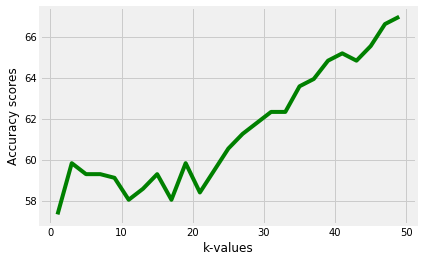

In [0]:
k=[]
s =[]
for i,j in acc_score:
    k.append(j)
    s.append(i)

plt.plot(k,s,color='g')

plt.xlabel("k-values")
plt.ylabel('Accuracy scores')
plt.show()



In [0]:
n=max(acc_score)
n=n[1]
n

49

In [0]:
knn_brute_bow=KNeighborsClassifier(n_jobs=2,n_neighbors=n,algorithm='brute')
knn_brute_bow.fit(x_tr,y_tr)
cv_pred =knn_brute_bow.predict(x_cv)
cv_acc = accuracy_score(y_cv,cv_pred)
print('Accuracry of Cross_validation:',cv_acc*100)

Accuracry of Cross_validation: 66.96428571428571


In [0]:
train_pred =knn_brute_bow.predict(x_tr)
train_acc =accuracy_score(y_tr,train_pred)
print('Accuracry of Train data:',train_acc*100)

Accuracry of Train data: 71.07142857142857


In [0]:
roc_auc_cv = roc_auc_score(y_cv,cv_pred)
fpr_cv,tpr_cv,thersholds = roc_curve(y_cv,cv_pred)
fpr_cv=fpr_cv[1]*100
print("False Positive Rate: {}".format(fpr_cv))

tpr_cv=tpr_cv[1]*100
print("True Positive Rate: {}".format(tpr_cv))

False Positive Rate: 40.714285714285715
True Positive Rate: 74.64285714285714


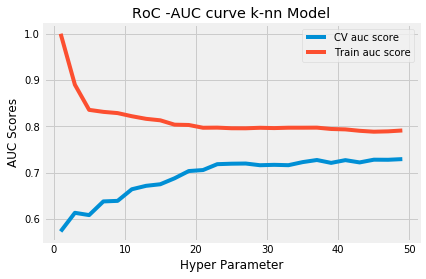

In [0]:
plt.plot(k,cv_auc_scores,label='CV auc score')
plt.plot(k,tr_auc_scores,label='Train auc score')

#plt.ylim([-0.05,1.05])
plt.legend(loc=0)

plt.xlabel('Hyper Parameter')
plt.ylabel('AUC Scores')
plt.title("RoC -AUC curve k-nn Model")

plt.show()

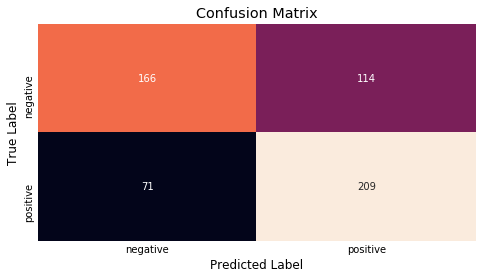

In [0]:
cm=confusion_matrix(y_cv,cv_pred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
plt.figure(figsize=(7,4))
sns.heatmap(df_cm, annot = True,cbar=False,fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [0]:
k = list(range(1,51,2))
print(k)   

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49]


In [0]:
param_grid=dict(n_neighbors=k)
print(param_grid)

{'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49]}


In [0]:
grid_brute_bow = GridSearchCV(knn_brute_bow, param_grid=param_grid,cv=10,scoring='accuracy',n_jobs=4)

In [0]:
grid_brute_bow.fit(x_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=2, n_neighbors=49, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [0]:
print("Best Parameter:",grid_brute_bow.best_estimator_)
print("Best Neighbors:",grid_brute_bow.best_params_)
print("Bset score:",grid_brute_bow.best_score_)

Best Parameter: KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=2, n_neighbors=43, p=2,
           weights='uniform')
Best Neighbors: {'n_neighbors': 43}
Bset score: 0.6885714285714286


In [0]:
model_1_bow  = KNeighborsClassifier(algorithm='brute',metric='minkowski',n_neighbors=grid_brute_bow.best_params_['n_neighbors'],weights='uniform',n_jobs=4)
model_1_bow.fit(x_train,y_train)
y_pred_1 = model_1_bow.predict(x_test)

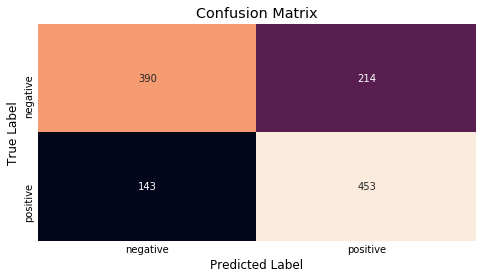

In [0]:
#Reference:
#https://www.kaggle.com/premvardhan/amazon-fine-food-reviews-analysis-using-knn
cm=confusion_matrix(y_test,y_pred_1)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
plt.figure(figsize=(7,4))
sns.heatmap(df_cm, annot = True,cbar=False,fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()

In [0]:
acc = accuracy_score(y_test,y_pred_1)*float(100)
print('Accuracy on Test Data : {:.2f} with k={}'.format(acc,grid_brute_bow.best_params_['n_neighbors']))
print("Accuracy on Train Data :{:.2f} with k={}".format(grid_brute_bow.best_score_*100,grid_brute_bow.best_params_['n_neighbors']))

Accuracy on Test Data : 70.25 with k=43
Accuracy on Train Data :68.86 with k=43


### Observations:

#### ROC and AUC 

In [0]:
roc_auc_test_bow = roc_auc_score(y_test,y_pred_1)
fpr_test,tpr_test,thersholds_test = roc_curve(y_test,model_1_bow.predict_proba(x_test)[:,1])

roc_auc_train_bow = roc_auc_score(y_train,model_1_bow.predict(x_train))
fpr_train,tpr_train,thersholds_train = roc_curve(y_train,model_1_bow.predict_proba(x_train)[:,1])

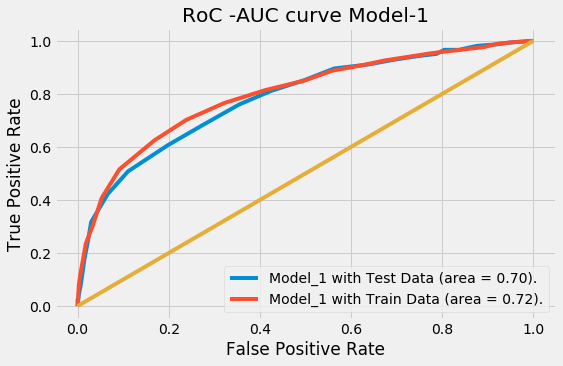

In [0]:
plt.figure(figsize=(8,5))
plt.style.use('fivethirtyeight')
plt.plot(fpr_test,tpr_test,label='Model_1 with Test Data (area = %.2f).'% roc_auc_test_bow)
plt.plot(fpr_train,tpr_train,label='Model_1 with Train Data (area = %.2f).'% roc_auc_train_bow)
plt.plot([0,1],[0,1])
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend(loc=0)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("RoC -AUC curve Model-1")

plt.show()

In [0]:
fpr=fpr_test[1]*100
print("False Positive Rate: {}".format(fpr))

tpr=tpr_test[1]*100
print("True Positive Rate: {}".format(tpr))

False Positive Rate: 0.0
True Positive Rate: 0.33557046979865773


# BoW with kd-tree

In [0]:
count_vect = CountVectorizer(min_df=10,max_features=500)
#count_vect.fit(preprocessed_reviews)
count_words = count_vect.fit_transform(preprocessed_reviews)

print("some feature names:",count_vect.get_feature_names()[:10])
print("The no.of unique words:",count_words.get_shape()[1])
print("The shape of the BOW:",count_words.get_shape())

some feature names: ['able', 'absolutely', 'actually', 'add', 'added', 'adding', 'aftertaste', 'ago', 'almost', 'also']
The no.of unique words: 500
The shape of the BOW: (4000, 500)


In [0]:
x=count_words.toarray()
print(x.shape)
print(y.shape)
print(type(x))

(4000, 500)
(4000,)
<class 'numpy.ndarray'>


In [0]:
scalar = StandardScaler()
scalar.fit_transform(x)

array([[-0.16363323, -0.1547815 , -0.20453335, ..., -0.23348152,
        -0.13165356, -0.15709123],
       [-0.16363323, -0.1547815 ,  3.41552588, ..., -0.23348152,
        -0.13165356, -0.15709123],
       [-0.16363323, -0.1547815 , -0.20453335, ..., -0.23348152,
        -0.13165356, -0.15709123],
       ...,
       [-0.16363323, -0.1547815 , -0.20453335, ..., -0.23348152,
        -0.13165356, -0.15709123],
       [-0.16363323, -0.1547815 , -0.20453335, ..., -0.23348152,
        -0.13165356,  6.00334903],
       [-0.16363323, -0.1547815 , -0.20453335, ..., -0.23348152,
        -0.13165356, -0.15709123]])

In [0]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=999)
x_train.shape

(2800, 500)

In [0]:
#split train data into cross validation train and cross validation test
x_tr,x_cv,y_tr,y_cv = train_test_split(x_train,y_train,test_size=0.2,random_state=99)

acc_score=[]
cv_auc_scores = []
tr_auc_scores = []


for i in range(1,50,2):
    knn_kd_bow = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree',n_jobs=4)
    knn_kd_bow.fit(x_tr,y_tr)
    pred_cv= knn_kd_bow.predict(x_cv)
    pred_tr = knn_kd_bow.predict(x_tr)
    
    acc = accuracy_score(y_cv,pred_cv,normalize=True)*float(100)
    acc_score.append((acc,i))
    
    roc_auc_cv = roc_auc_score(y_cv,pred_cv)
    fpr_cv,tpr_cv,thersholds_cv = roc_curve(y_cv,knn_kd_bow.predict_proba(x_cv)[:,1])
    cv_auc_scores.append(auc(fpr_cv,tpr_cv))
    

    roc_auc_tr = roc_auc_score(y_tr,pred_tr)
    fpr_tr,tpr_tr,thersholds_tr = roc_curve(y_tr,knn_kd_bow.predict_proba(x_tr)[:,1])
    tr_auc_scores.append(auc(fpr_tr,tpr_tr))
    
    print("\nCV Accuracy for k={} is {:.2f}".format(i,acc))
    
print(10*'===')
print("Best accuracy:",max(acc_score))


CV Accuracy for k=1 is 57.86

CV Accuracy for k=3 is 60.36

CV Accuracy for k=5 is 60.89

CV Accuracy for k=7 is 60.36

CV Accuracy for k=9 is 61.96

CV Accuracy for k=11 is 62.68

CV Accuracy for k=13 is 62.86

CV Accuracy for k=15 is 62.32

CV Accuracy for k=17 is 62.86

CV Accuracy for k=19 is 63.75

CV Accuracy for k=21 is 62.68

CV Accuracy for k=23 is 62.86

CV Accuracy for k=25 is 63.57

CV Accuracy for k=27 is 65.00

CV Accuracy for k=29 is 63.21

CV Accuracy for k=31 is 64.46

CV Accuracy for k=33 is 64.64

CV Accuracy for k=35 is 63.57

CV Accuracy for k=37 is 65.54

CV Accuracy for k=39 is 65.00

CV Accuracy for k=41 is 66.07

CV Accuracy for k=43 is 64.82

CV Accuracy for k=45 is 65.36

CV Accuracy for k=47 is 66.79

CV Accuracy for k=49 is 64.64
Best accuracy: (66.78571428571428, 47)


In [0]:
n=max(acc_score)
n = n[1]
n

47

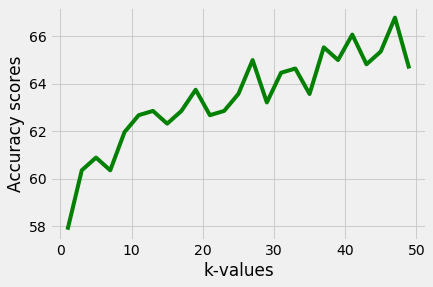

In [0]:
k=[]
s =[]
for i,j in acc_score:
    k.append(j)
    s.append(i)

plt.plot(k,s,color='g')

plt.xlabel("k-values")
plt.ylabel('Accuracy scores')
plt.show()


In [0]:
knn_kd_bow=KNeighborsClassifier(n_jobs=4,n_neighbors=n,algorithm='kd_tree')
knn_kd_bow.fit(x_tr,y_tr)
cv_pred =knn_kd_bow.predict(x_cv)
cv_acc = accuracy_score(y_cv,cv_pred)
print('Accuracry of Cross_validation:',cv_acc*100)

Accuracry of Cross_validation: 66.78571428571428


In [0]:
train_pred =knn_kd_bow.predict(x_tr)
train_acc =accuracy_score(y_tr,train_pred)
print('Accuracry of Train data:',train_acc*100)

Accuracry of Train data: 73.03571428571428


In [0]:
roc_auc_cv = roc_auc_score(y_cv,cv_pred)
fpr_cv,tpr_cv,thersholds = roc_curve(y_cv,cv_pred)
fpr_cv=fpr_cv[1]*100
print("False Positive Rate: {}".format(fpr_cv))

tpr_cv=tpr_cv[1]*100
print("True Positive Rate: {}".format(tpr_cv))

False Positive Rate: 35.35714285714286
True Positive Rate: 68.92857142857143


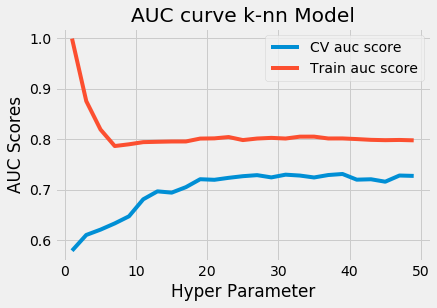

In [0]:
plt.plot(k,cv_auc_scores,label='CV auc score')
plt.plot(k,tr_auc_scores,label='Train auc score')

#plt.ylim([-0.05,1.05])
plt.legend(loc=0)

plt.xlabel('Hyper Parameter')
plt.ylabel('AUC Scores')
plt.title("AUC curve k-nn Model")

plt.show()

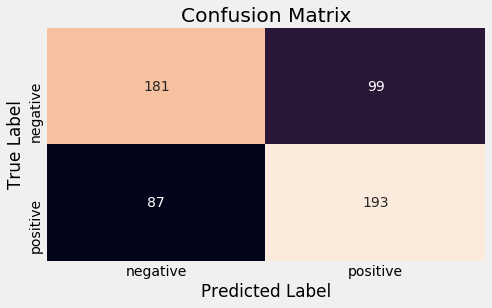

In [0]:
cm=confusion_matrix(y_cv,cv_pred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
plt.figure(figsize=(7,4))
sns.heatmap(df_cm, annot = True,cbar=False,fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [0]:
knn_kd_bow = KNeighborsClassifier(n_neighbors=n,algorithm='kd_tree', n_jobs=4)

In [0]:
grid_kd_bow = GridSearchCV(knn_kd_bow, param_grid=param_grid,cv=3,scoring='accuracy',n_jobs=4)

In [0]:
grid_kd_bow.fit(x_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=4, n_neighbors=47, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [0]:
print("Best Parameter:",grid_kd_bow.best_estimator_)
print("Best Neighbors:",grid_kd_bow.best_params_)
print("Bset score:",grid_kd_bow.best_score_)

Best Parameter: KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=4, n_neighbors=21, p=2,
           weights='uniform')
Best Neighbors: {'n_neighbors': 21}
Bset score: 0.6903571428571429


In [0]:
grid_kd_bow.best_params_['n_neighbors']

21

In [0]:
model_2_kd = KNeighborsClassifier(n_jobs=4,n_neighbors=grid_kd_bow.best_params_['n_neighbors'],metric='minkowski',algorithm='kd_tree',weights='uniform')
model_2_kd.fit(x_train,y_train)
y_pred_2 = model_2_kd.predict(x_test)
y_train_2 = model_2_kd.predict(x_train)

In [0]:
test_acc_2 =accuracy_score(y_test,y_pred_2)
train_acc_2 = accuracy_score(y_train,y_train_2)

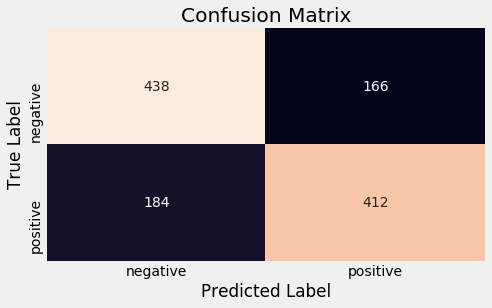

In [0]:
cm=confusion_matrix(y_test,y_pred_2)
#Reference:
#https://www.kaggle.com/premvardhan/amazon-fine-food-reviews-analysis-using-knn
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
plt.figure(figsize=(7,4))
sns.heatmap(df_cm, annot = True,cbar=False,fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()


In [0]:
acc = accuracy_score(y_test,y_pred_2)*float(100)
print('Accuracy on Test Data : {} with k={}'.format(test_acc_2*100,grid_kd_bow.best_params_['n_neighbors']))
print("Accuracy on Train Data :{} with k={}".format(train_acc_2*100,grid_kd_bow.best_params_['n_neighbors']))

Accuracy on Test Data : 70.83333333333334 with k=21
Accuracy on Train Data :74.78571428571429 with k=21


In [0]:
#roc_auc_2_test= roc_auc_score(y_test,y_pred_2)
#fpr_test_2,tpr_test_2,thersholds = roc_curve(y_test,model_2_kd.predict_proba(x_test)[:,1])

#roc_auc_test_bow = roc_auc_score(y_test,y_pred_1)
#fpr_test,tpr_test,thersholds_test = roc_curve(y_test,model_1_bow.predict_proba(x_test)[:,1])

#roc_auc_train_bow = roc_auc_score(y_train,model_1_bow.predict(x_train))
#fpr_train,tpr_train,thersholds_train = roc_curve(y_train,model_1_bow.predict_proba(x_train)[:,1])

roc_auc_test_2 = roc_auc_score(y_test,y_pred_1)
fpr_test_2,tpr_test_2,thersholds = roc_curve(y_test,model_2_kd.predict_proba(x_test)[:,1])

roc_auc_train_2 = roc_auc_score(y_train,y_train_2)
fpr_train_2,tpr_train_2,thersholds_2 = roc_curve(y_test,model_2_kd.predict_proba(x_test)[:,1])

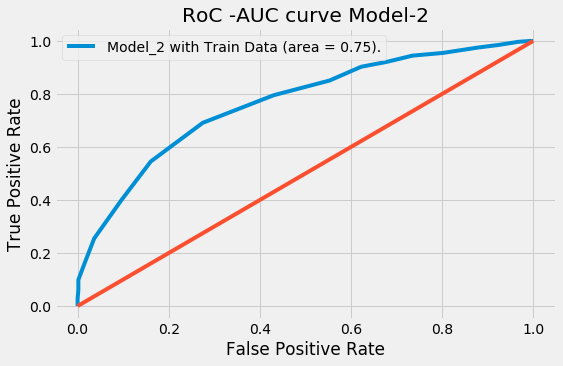

In [0]:
plt.figure(figsize=(8,5))
plt.plot(fpr_train_2,tpr_train_2,label='Model_2 with Train Data (area = %.2f).'% roc_auc_train_2)
#plt.plot(fpr_test_2,tpr_test_2,label='Model_2 with Test Data (area = %.2f).'% roc_auc_test_2)
plt.plot([0,1],[0,1])
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend(loc=0)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("RoC -AUC curve Model-2")

plt.show()

## Comparing KD-tree and Bruteforce models of BoW

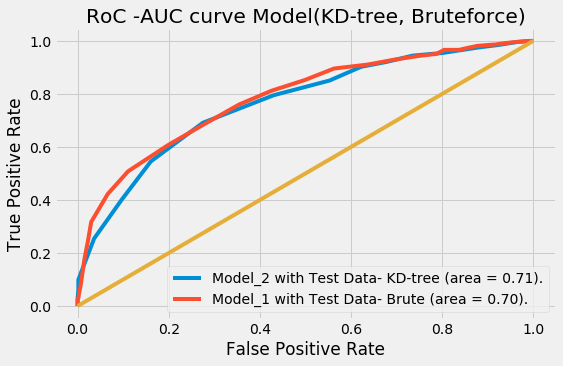

In [0]:
plt.figure(figsize=(8,5))
plt.plot(fpr_test_2,tpr_test_2,label='Model_2 with Test Data- KD-tree (area = %.2f).'% roc_auc_test_2)
plt.plot(fpr_test,tpr_test,label='Model_1 with Test Data- Brute (area = %.2f).'% roc_auc_test_bow)
plt.plot([0,1],[0,1])
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("RoC -AUC curve Model(KD-tree, Bruteforce)",loc='center')
plt.show()


In [0]:
kd_tree_auc_bow = auc(fpr_test_2,tpr_test_2)
brute_auc_bow = auc(fpr_test,tpr_test)
print("AUC kd-tee: %.2f"% kd_tree_auc_bow)
print("AUC brute: %.2f"% brute_auc_bow)

AUC kd-tee: 0.77
AUC brute: 0.78


## Conclusion: BoW

In [0]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = [ "Vectorizer","Model","Hyper Parameter(k)", 'AUC']
x.add_row(["BoW", "Brute", grid_brute_bow.best_params_['n_neighbors'], np.round(brute_auc_bow,2)])
x.add_row(["BoW", "KD-tree", grid_kd_bow.best_params_['n_neighbors'],np.round(kd_tree_auc_bow,2)])

print(x)

+------------+---------+--------------------+------+
| Vectorizer |  Model  | Hyper Parameter(k) | AUC  |
+------------+---------+--------------------+------+
|    BoW     |  Brute  |         43         | 0.78 |
|    BoW     | KD-tree |         21         | 0.77 |
+------------+---------+--------------------+------+


#### Observations:

# 7.2-Bi-Grams and n-grams

In [0]:
count_vect = CountVectorizer(ngram_range=(1,2),min_df=10,max_features=500)
count_words = count_vect.fit_transform(preprocessed_reviews)
print("The Bi-grams of some words:",count_vect.get_feature_names()[:10])
print("The shape of Bi-grams:",count_words.get_shape())

The Bi-grams of some words: ['able', 'absolutely', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almost', 'along', 'also']
The shape of Bi-grams: (5785, 500)


In [0]:
x=count_words
print(type(x))
print(x.shape)
x = x.toarray()
print(x.shape)
print(type(x))

y =np.array( df['Score']).reshape(-1,1)
print(y.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(5785, 500)
(5785, 500)
<class 'numpy.ndarray'>
(5785, 1)


# 7.3-TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=5)
tf_idf_words = tf_idf_vect.fit_transform(preprocessed_reviews)

print("The shape of Tf-Idf:",tf_idf_words.get_shape())
print("Some of words in Tf-Idf words:",tf_idf_vect.get_feature_names()[:10])


The shape of Tf-Idf: (5785, 7823)
Some of words in Tf-Idf words: ['ability', 'able', 'able buy', 'able find', 'able get', 'able make', 'able order', 'able purchase', 'able use', 'absolute']


In [0]:
x=tf_idf_words
print(type(x))
print(x.shape)
x = x.toarray()
print(x.shape)
print(type(x))

y =np.array( df['Score']).reshape(-1,1)
print(y.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(5785, 7823)
(5785, 7823)
<class 'numpy.ndarray'>
(5785, 1)


In [0]:
scalar = StandardScaler()
x=scalar.fit_transform(x)

In [0]:
x.shape

(5785, 7823)

In [0]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=999)
x_train.shape

(4049, 7823)

In [0]:
x_test.shape

(1736, 7823)

## 7.3.1 tf-idf with brute force

### Cross validation tf-idf bruteforce

In [0]:
#split train data into cross validation train and cross validation test
x_tr,x_cv,y_tr,y_cv = train_test_split(x_train,y_train,test_size=0.2,random_state=9)

acc_score=[]
cv_auc_scores = []
tr_auc_scores = []


for i in range(1,50,2):
    knn_brute_tf = KNeighborsClassifier(n_neighbors=i,algorithm='brute',n_jobs=4)
    knn_brute_tf.fit(x_tr,y_tr)
    pred_cv= knn_brute_tf.predict(x_cv)
    pred_tr = knn_brute_tf.predict(x_tr)
    
    acc = accuracy_score(y_cv,pred_cv,normalize=True)*float(100)
    acc_score.append((acc,i))
    
    roc_auc_cv = roc_auc_score(y_cv,pred_cv)
    fpr_cv,tpr_cv,thersholds_cv = roc_curve(y_cv,knn_brute_tf.predict_proba(x_cv)[:,1])
    cv_auc_scores.append(auc(fpr_cv,tpr_cv))
    

    roc_auc_tr = roc_auc_score(y_tr,pred_tr)
    fpr_tr,tpr_tr,thersholds_tr = roc_curve(y_tr,knn_brute_tf.predict_proba(x_tr)[:,1])
    tr_auc_scores.append(auc(fpr_tr,tpr_tr))
    
    print("\nCV Accuracy for k={} is {:.2f}".format(i,acc))
    
print(10*'===')
print("Best accuracy:",max(acc_score))


CV Accuracy for k=1 is 82.72

CV Accuracy for k=3 is 84.32

CV Accuracy for k=5 is 84.20

CV Accuracy for k=7 is 84.20

CV Accuracy for k=9 is 84.20

CV Accuracy for k=11 is 84.20

CV Accuracy for k=13 is 84.20

CV Accuracy for k=15 is 84.20

CV Accuracy for k=17 is 84.20

CV Accuracy for k=19 is 84.20

CV Accuracy for k=21 is 84.20

CV Accuracy for k=23 is 84.20

CV Accuracy for k=25 is 84.20

CV Accuracy for k=27 is 84.20

CV Accuracy for k=29 is 84.20

CV Accuracy for k=31 is 84.20

CV Accuracy for k=33 is 84.20

CV Accuracy for k=35 is 84.20

CV Accuracy for k=37 is 84.20

CV Accuracy for k=39 is 84.20

CV Accuracy for k=41 is 84.20

CV Accuracy for k=43 is 84.20

CV Accuracy for k=45 is 84.20

CV Accuracy for k=47 is 84.20

CV Accuracy for k=49 is 84.20
Best accuracy: (84.32098765432099, 3)


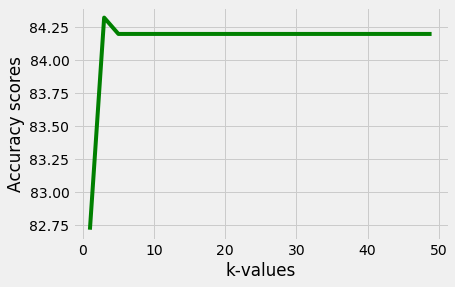

Best_k:  3


In [0]:
k=[]
s =[]
for i,j in acc_score:
    k.append(j)
    s.append(i)

plt.plot(k,s,color='g')

plt.xlabel("k-values")
plt.ylabel('Accuracy scores')
plt.show()

n=max(acc_score)
n=n[1]
print('Best_k: ',n)

In [0]:
knn_brute_tf=KNeighborsClassifier(n_jobs=2,n_neighbors=n,algorithm='brute')
knn_brute_tf.fit(x_tr,y_tr)
cv_pred =knn_brute_tf.predict(x_cv)
cv_acc = accuracy_score(y_cv,cv_pred)
print('Accuracry of Cross_validation:',cv_acc*100)

train_pred =knn_brute_tf.predict(x_tr)
train_acc =accuracy_score(y_tr,train_pred)
print('Accuracry of Train data:',train_acc*100)

Accuracry of Cross_validation: 84.32098765432099
Accuracry of Train data: 86.16857054646496


In [0]:
roc_auc_cv = roc_auc_score(y_cv,cv_pred)
fpr_cv,tpr_cv,thersholds = roc_curve(y_cv,cv_pred)
fpr_cv=fpr_cv[1]*100
print("False Positive Rate: {}".format(fpr_cv))

tpr_cv=tpr_cv[1]*100
print("True Positive Rate: {}".format(tpr_cv))

False Positive Rate: 98.4375
True Positive Rate: 99.8533724340176


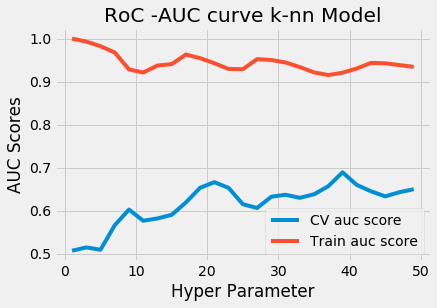

In [0]:
plt.plot(k,cv_auc_scores,label='CV auc score')
plt.plot(k,tr_auc_scores,label='Train auc score')

#plt.ylim([-0.05,1.05])
plt.legend(loc=0)

plt.xlabel('Hyper Parameter')
plt.ylabel('AUC Scores')
plt.title("RoC -AUC curve k-nn Model")

plt.show()

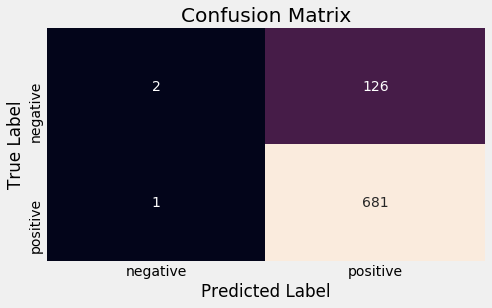

In [0]:
cm=confusion_matrix(y_cv,cv_pred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
plt.figure(figsize=(7,4))
sns.heatmap(df_cm, annot = True,cbar=False,fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### GridSearchCV tf-idf

In [0]:
k = list(range(1,51,2))
print(k)   

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49]


In [0]:
param_grid=dict(n_neighbors=k)
print(param_grid)

{'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49]}


In [0]:
grid_brute_tf = GridSearchCV(knn_brute_tf, param_grid=param_grid,cv=5,scoring='accuracy',n_jobs=4)
grid_brute_tf.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='brute', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=2,
                                            n_neighbors=3, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=4,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29, 31, 33, 35, 37, 39, 41,
                                         43, 45, 47, 49]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [0]:
print("Best Parameter:",grid_brute_tf.best_estimator_)
print("Best k-Neighbors:",grid_brute_tf.best_params_)
print()
print("Bset score:",grid_brute_tf.best_score_)

Best Parameter: KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=2, n_neighbors=7, p=2,
                     weights='uniform')
Best k-Neighbors: {'n_neighbors': 7}

Bset score: 0.8478636700419857


In [0]:
model_1_tf  = KNeighborsClassifier(algorithm='brute',metric='minkowski',n_neighbors=grid_brute_tf.best_params_['n_neighbors'],weights='uniform',n_jobs=4)
model_1_tf.fit(x_train,y_train)
y_pred_1 = model_1_tf.predict(x_test)

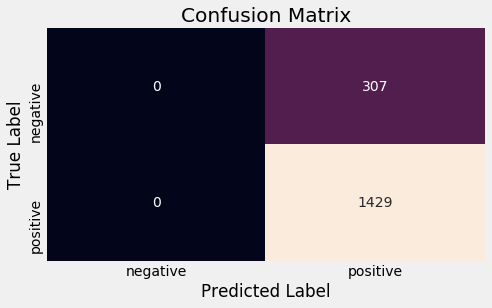

In [0]:
#Reference:
#https://www.kaggle.com/premvardhan/amazon-fine-food-reviews-analysis-using-knn
cm=confusion_matrix(y_test,y_pred_1)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
plt.figure(figsize=(7,4))
sns.heatmap(df_cm, annot = True,cbar=False,fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()

In [0]:
acc = accuracy_score(y_test,y_pred_1)*float(100)
print('Accuracy on Test Data : {:.2f} with k={}'.format(acc,grid_brute_tf.best_params_['n_neighbors']))
print("Accuracy on Train Data :{:.2f} with k={}".format(grid_brute_tf.best_score_*100,grid_brute_tf.best_params_['n_neighbors']))

Accuracy on Test Data : 82.32 with k=7
Accuracy on Train Data :84.79 with k=7


### ROC and AUC -tf-idf (grid_cv)

In [0]:
roc_auc_test_tf = roc_auc_score(y_test,y_pred_1)
fpr_test,tpr_test,thersholds_test = roc_curve(y_test,model_1_tf.predict_proba(x_test)[:,1])

roc_auc_train_tf = roc_auc_score(y_train,model_1_tf.predict(x_train))
fpr_train,tpr_train,thersholds_train = roc_curve(y_train,model_1_tf.predict_proba(x_train)[:,1])

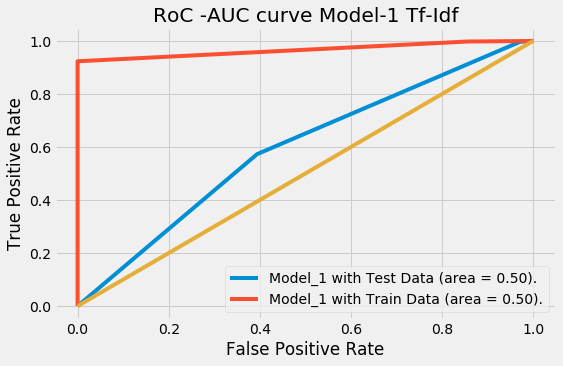

In [0]:
plt.figure(figsize=(8,5))
plt.style.use('fivethirtyeight')
plt.plot(fpr_test,tpr_test,label='Model_1 with Test Data (area = %.2f).'% roc_auc_test_tf)
plt.plot(fpr_train,tpr_train,label='Model_1 with Train Data (area = %.2f).'% roc_auc_train_tf)
plt.plot([0,1],[0,1])
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend(loc=0)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("RoC -AUC curve Model-1 Tf-Idf")

plt.show()

In [0]:
fpr=fpr_test[1]*100
print("False Positive Rate: {}".format(fpr))

tpr=tpr_test[1]*100
print("True Positive Rate: {}".format(tpr))

False Positive Rate: 39.413680781758956
True Positive Rate: 57.312806158152554


## 7.3.2Tf-Idf with kd-tree

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=5,max_features=500)
tf_idf_words = tf_idf_vect.fit_transform(preprocessed_reviews)

print("The shape of Tf-Idf:",tf_idf_words.get_shape())
print("Some of words in Tf-Idf words:",tf_idf_vect.get_feature_names()[:10])


The shape of Tf-Idf: (5785, 500)
Some of words in Tf-Idf words: ['able', 'absolutely', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almost', 'along', 'also']


In [0]:
x=tf_idf_words.toarray()
print(x.shape)
print(y.shape)
print(type(x))

(5785, 500)
(5785, 1)
<class 'numpy.ndarray'>


In [0]:
scalar = StandardScaler()
x=scalar.fit_transform(x)
x.shape

(5785, 500)

In [0]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=999)
x_train.shape

(4049, 500)

In [0]:
#split train data into cross validation train and cross validation test
x_tr,x_cv,y_tr,y_cv = train_test_split(x_train,y_train,test_size=0.2,random_state=99)

acc_score=[]
cv_auc_scores = []
tr_auc_scores = []


for i in range(1,50,2):
    knn_kd_tf = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree',n_jobs=4)
    knn_kd_tf.fit(x_tr,y_tr)
    pred_cv= knn_kd_tf.predict(x_cv)
    pred_tr = knn_kd_tf.predict(x_tr)
    
    acc = accuracy_score(y_cv,pred_cv,normalize=True)*float(100)
    acc_score.append((acc,i))
    
    roc_auc_cv = roc_auc_score(y_cv,pred_cv)
    fpr_cv,tpr_cv,thersholds_cv = roc_curve(y_cv,knn_kd_tf.predict_proba(x_cv)[:,1])
    cv_auc_scores.append(auc(fpr_cv,tpr_cv))
    

    roc_auc_tr = roc_auc_score(y_tr,pred_tr)
    fpr_tr,tpr_tr,thersholds_tr = roc_curve(y_tr,knn_kd_tf.predict_proba(x_tr)[:,1])
    tr_auc_scores.append(auc(fpr_tr,tpr_tr))
    
    print("\nCV Accuracy for k={} is {:.2f}".format(i,acc))
    
print(10*'===')
print("Best accuracy:",max(acc_score))


CV Accuracy for k=1 is 77.16

CV Accuracy for k=3 is 83.83

CV Accuracy for k=5 is 86.42

CV Accuracy for k=7 is 86.79

CV Accuracy for k=9 is 86.79

CV Accuracy for k=11 is 86.67

CV Accuracy for k=13 is 86.30

CV Accuracy for k=15 is 86.67

CV Accuracy for k=17 is 86.67

CV Accuracy for k=19 is 86.67

CV Accuracy for k=21 is 86.54

CV Accuracy for k=23 is 86.54

CV Accuracy for k=25 is 86.42

CV Accuracy for k=27 is 86.42

CV Accuracy for k=29 is 86.42

CV Accuracy for k=31 is 86.42

CV Accuracy for k=33 is 86.42

CV Accuracy for k=35 is 86.42

CV Accuracy for k=37 is 86.42

CV Accuracy for k=39 is 86.42

CV Accuracy for k=41 is 86.42

CV Accuracy for k=43 is 86.42

CV Accuracy for k=45 is 86.42

CV Accuracy for k=47 is 86.42

CV Accuracy for k=49 is 86.42
Best accuracy: (86.79012345679013, 9)


In [0]:
n=max(acc_score)
n = n[1]
n

9

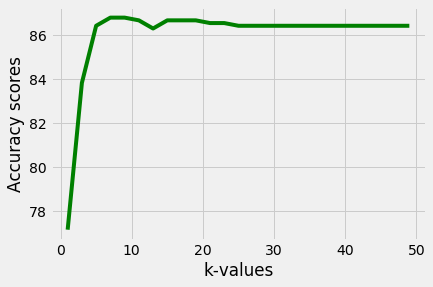

In [0]:
k=[]
s =[]
for i,j in acc_score:
    k.append(j)
    s.append(i)

plt.plot(k,s,color='g')

plt.xlabel("k-values")
plt.ylabel('Accuracy scores')
plt.show()


In [0]:
knn_kd_tf=KNeighborsClassifier(n_jobs=4,n_neighbors=n,algorithm='kd_tree')
knn_kd_tf.fit(x_tr,y_tr)
cv_pred =knn_kd_tf.predict(x_cv)
cv_acc = accuracy_score(y_cv,cv_pred)
print('Accuracry of Cross_validation:',cv_acc*100)

Accuracry of Cross_validation: 86.79012345679013


In [0]:
train_pred =knn_kd_tf.predict(x_tr)
train_acc =accuracy_score(y_tr,train_pred)
print('Accuracry of Train data:',train_acc*100)

Accuracry of Train data: 86.41556035813522


In [0]:
roc_auc_cv = roc_auc_score(y_cv,cv_pred)
fpr_cv,tpr_cv,thersholds = roc_curve(y_cv,cv_pred)
fpr_cv=fpr_cv[1]*100
print("False Positive Rate: {}".format(fpr_cv))

tpr_cv=tpr_cv[1]*100
print("True Positive Rate: {}".format(tpr_cv))

False Positive Rate: 91.81818181818183
True Positive Rate: 99.14285714285714


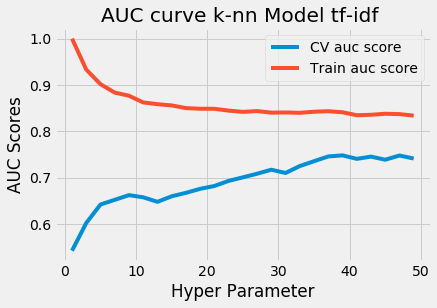

In [0]:
plt.plot(k,cv_auc_scores,label='CV auc score')
plt.plot(k,tr_auc_scores,label='Train auc score')

#plt.ylim([-0.05,1.05])
plt.legend(loc=0)

plt.xlabel('Hyper Parameter')
plt.ylabel('AUC Scores')
plt.title("AUC curve k-nn Model tf-idf ")

plt.show()

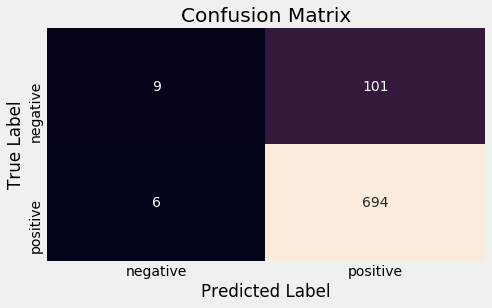

In [0]:
cm=confusion_matrix(y_cv,cv_pred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
plt.figure(figsize=(7,4))
sns.heatmap(df_cm, annot = True,cbar=False,fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### GridSearchCV tf-idf

In [0]:
knn_kd_tf = KNeighborsClassifier(n_neighbors=n,algorithm='kd_tree', n_jobs=4)
grid_kd_tf = GridSearchCV(knn_kd_tf, param_grid=param_grid,cv=3,scoring='accuracy',n_jobs=4)
grid_kd_tf.fit(x_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='kd_tree', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=4,
                                            n_neighbors=9, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=4,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29, 31, 33, 35, 37, 39, 41,
                                         43, 45, 47, 49]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [0]:
print("Best Parameter:",grid_kd_tf.best_estimator_)
print("Best Neighbors:",grid_kd_tf.best_params_)
print("Bset score:",grid_kd_tf.best_score_)

Best Parameter: KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=4, n_neighbors=9, p=2,
                     weights='uniform')
Best Neighbors: {'n_neighbors': 9}
Bset score: 0.8513213139046678


In [0]:
model_2_kd_tf = KNeighborsClassifier(n_jobs=4,n_neighbors=grid_kd_tf.best_params_['n_neighbors'],metric='minkowski',algorithm='kd_tree',weights='uniform')
model_2_kd_tf.fit(x_train,y_train)
y_pred_2 = model_2_kd_tf.predict(x_test)
y_train_2 = model_2_kd_tf.predict(x_train)

In [0]:
test_acc_2 =accuracy_score(y_test,y_pred_2)
train_acc_2 = accuracy_score(y_train,y_train_2)

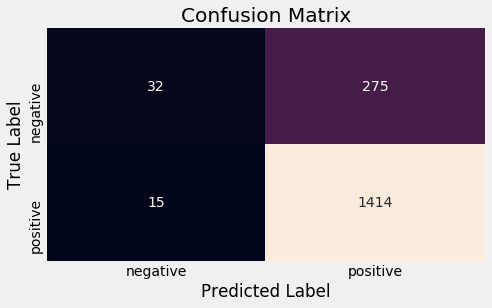

In [0]:
cm=confusion_matrix(y_test,y_pred_2)
#Reference:
#https://www.kaggle.com/premvardhan/amazon-fine-food-reviews-analysis-using-knn
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
plt.figure(figsize=(7,4))
sns.heatmap(df_cm, annot = True,cbar=False,fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()


In [0]:
acc = accuracy_score(y_test,y_pred_2)*float(100)
print('Accuracy on Test Data : {} with k={}'.format(test_acc_2*100,grid_kd_tf.best_params_['n_neighbors']))
print("Accuracy on Train Data :{} with k={}".format(train_acc_2*100,grid_kd_tf.best_params_['n_neighbors']))

Accuracy on Test Data : 83.29493087557603 with k=9
Accuracy on Train Data :86.53988639170166 with k=9


In [0]:
roc_auc_test_tf_2= roc_auc_score(y_test,y_pred_1)
fpr_test_2,tpr_test_2,thersholds = roc_curve(y_test,model_2_kd_tf.predict_proba(x_test)[:,1])

roc_auc_train_tf = roc_auc_score(y_train,y_train_2)
fpr_train_2,tpr_train_2,thersholds_2 = roc_curve(y_test,model_2_kd_tf.predict_proba(x_test)[:,1])

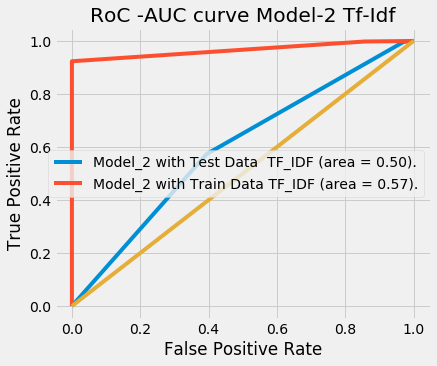

In [0]:
plt.figure(figsize=(6,5))
plt.style.use('fivethirtyeight')
plt.plot(fpr_test,tpr_test,label='Model_2 with Test Data  TF_IDF (area = %.2f).'% roc_auc_test_tf_2)
plt.plot(fpr_train,tpr_train,label='Model_2 with Train Data TF_IDF (area = %.2f).'% roc_auc_train_tf)
plt.plot([0,1],[0,1])
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend(loc=0)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("RoC -AUC curve Model-2 Tf-Idf")

plt.show()





##7.3.3 Comparing KD-tree and Bruteforce models of BoW

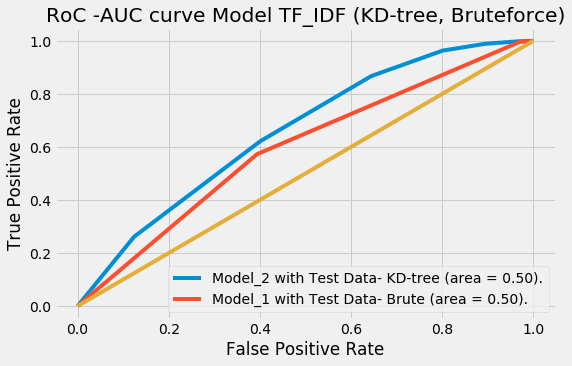

In [0]:
plt.figure(figsize=(8,5))
plt.plot(fpr_test_2,tpr_test_2,label='Model_2 with Test Data- KD-tree (area = %.2f).'% roc_auc_test_tf_2)
plt.plot(fpr_test,tpr_test,label='Model_1 with Test Data- Brute (area = %.2f).'% roc_auc_test_tf)
plt.plot([0,1],[0,1])
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("RoC -AUC curve Model TF_IDF (KD-tree, Bruteforce)",loc='center')
plt.show()


In [0]:
kd_tree_auc_tf = auc(fpr_test_2,tpr_test_2)
brute_auc_tf = auc(fpr_test,tpr_test)
print("AUC kd-tee: %.2f"% kd_tree_auc_tf)
print("AUC brute: %.2f"% brute_auc_tf)

AUC kd-tee: 0.66
AUC brute: 0.59


# TF_IDF Conclusion

In [0]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = [ "Vectorizer","Model","Hyper Parameter(k)", 'AUC']
x.add_row(["TF-IDF", "Brute", grid_brute_tf.best_params_['n_neighbors'], np.round(brute_auc_tf,2)])
x.add_row(["TF-IDF", "KD-tree", grid_kd_tf.best_params_['n_neighbors'],np.round(kd_tree_auc_tf,2)])

print(x)

+------------+---------+--------------------+------+
| Vectorizer |  Model  | Hyper Parameter(k) | AUC  |
+------------+---------+--------------------+------+
|   TF-IDF   |  Brute  |         7          | 0.59 |
|   TF-IDF   | KD-tree |         9          | 0.66 |
+------------+---------+--------------------+------+


# 7.4-Word2Vec

In [0]:
list_of_sentence =[]
for sentence in preprocessed_reviews:
    list_of_sentence.append(sentence.split())
#list_of_sentence = preprocessed_reviews.split()

In [0]:
w2v_model = Word2Vec(list_of_sentence,min_count=5,size=50,workers=4)
print(w2v_model.wv.most_similar('great'))
print('==='*10)
print(w2v_model.wv.most_similar('worst'))


[('excellent', 0.9872217178344727), ('definately', 0.9837388396263123), ('looking', 0.9797815084457397), ('think', 0.9788758754730225), ('definitely', 0.9787260293960571), ('overall', 0.9784457683563232), ('value', 0.9767886996269226), ('quite', 0.9753962755203247), ('anything', 0.9752956032752991), ('surely', 0.974970817565918)]
[('american', 0.9990604519844055), ('hands', 0.9990181922912598), ('clam', 0.9987296462059021), ('awful', 0.9986768960952759), ('gourmet', 0.9986250996589661), ('varieties', 0.9985925555229187), ('alternatives', 0.9985694289207458), ('unlike', 0.9985508918762207), ('among', 0.998540461063385), ('blends', 0.9985353946685791)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("The numbers of that occured minimum 5 Times:",len(w2v_words))
print("Sample words:",w2v_words[:10])

The numbers of that occured minimum 5 Times: 4280
Sample words: ['bought', 'several', 'canned', 'dog', 'food', 'products', 'found', 'good', 'quality', 'product']


In [0]:
#computing avg word2vec for each review

sent_vectors =[]

for sent in tqdm(list_of_sentence):
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in w2v_words:
        vec = w2v_model.wv[word]
        sent_vec +=vec
        cnt_words +=1
    if cnt_words !=0:
        sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
  
  
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 5785/5785 [01:20<00:00, 71.46it/s]

5785
50


In [0]:
sent_vectors[0]

array([-1.38261898e-01, -5.60912992e-02, -1.32412510e-01, -6.68365021e-02,
       -1.69968710e-01, -1.70249994e-01,  2.18971198e-01,  1.16052759e-01,
       -4.29825318e-01,  7.34626287e-02,  1.29830888e-03,  2.19374110e-01,
       -3.91543393e-02,  2.23448632e-01, -1.04604143e-01, -3.85084587e-01,
       -3.01980206e-03,  1.77775786e-01,  3.01863675e-01, -1.73228091e-01,
        8.47798321e-02, -2.70545771e-01, -1.03674040e-01, -3.02238245e-02,
        5.97519405e-02,  1.02720322e-01, -1.75308837e-01, -2.53364139e-01,
       -1.08279056e-01,  1.86033251e-01,  3.79978539e-02, -3.83359273e-01,
       -6.19993265e-03,  1.16997243e-01,  1.60185152e-01,  4.12012076e-02,
        1.60281355e-01,  9.91051340e-02, -1.88177754e-01, -1.81304501e-01,
       -1.77123373e-04,  2.55801899e-01,  9.82955139e-02,  1.00789633e-01,
       -1.24384839e-01,  6.88668377e-02, -3.73492884e-01,  1.48470454e-03,
        7.28340994e-02,  1.16298320e-01])

In [0]:
x =np.array(sent_vectors)
print(type(x))
print(x.shape)

print(x.shape)
print(type(x))

y =np.array( df['Score'])
print(y.shape)

<class 'numpy.ndarray'>
(5785, 50)
(5785, 50)
<class 'numpy.ndarray'>
(5785,)


In [0]:
scalar = StandardScaler()
x=scalar.fit_transform(x)
x.shape

(5785, 50)

In [0]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=999)
x_train.shape

(4049, 50)

## 7.4.1 Brute force with avg.W2V

In [0]:
#split train data into cross validation train and cross validation test
x_tr,x_cv,y_tr,y_cv = train_test_split(x_train,y_train,test_size=0.2,random_state=99)

acc_score=[]
cv_auc_scores = []
tr_auc_scores = []


for i in range(1,50,2):
    knn_brute_w2v = KNeighborsClassifier(n_neighbors=i,algorithm='brute',n_jobs=4)
    knn_brute_w2v.fit(x_tr,y_tr)
    pred_cv= knn_brute_w2v.predict(x_cv)
    pred_tr = knn_brute_w2v.predict(x_tr)
    
    acc = accuracy_score(y_cv,pred_cv,normalize=True)*float(100)
    acc_score.append((acc,i))
    
    roc_auc_cv = roc_auc_score(y_cv,pred_cv)
    fpr_cv,tpr_cv,thersholds_cv = roc_curve(y_cv,knn_brute_w2v.predict_proba(x_cv)[:,1])
    cv_auc_scores.append(auc(fpr_cv,tpr_cv))
    

    roc_auc_tr = roc_auc_score(y_tr,pred_tr)
    fpr_tr,tpr_tr,thersholds_tr = roc_curve(y_tr,knn_brute_w2v.predict_proba(x_tr)[:,1])
    tr_auc_scores.append(auc(fpr_tr,tpr_tr))
    
    print("\nCV Accuracy for k={} is {:.2f}".format(i,acc))
    
print(10*'===')
print("Best accuracy:",max(acc_score))


CV Accuracy for k=1 is 86.42

CV Accuracy for k=3 is 86.42

CV Accuracy for k=5 is 86.42

CV Accuracy for k=7 is 86.42

CV Accuracy for k=9 is 86.42

CV Accuracy for k=11 is 86.42

CV Accuracy for k=13 is 86.42

CV Accuracy for k=15 is 86.42

CV Accuracy for k=17 is 86.42

CV Accuracy for k=19 is 86.42

CV Accuracy for k=21 is 86.42

CV Accuracy for k=23 is 86.42

CV Accuracy for k=25 is 86.42

CV Accuracy for k=27 is 86.42

CV Accuracy for k=29 is 86.42

CV Accuracy for k=31 is 86.42

CV Accuracy for k=33 is 86.42

CV Accuracy for k=35 is 86.42

CV Accuracy for k=37 is 86.42

CV Accuracy for k=39 is 86.42

CV Accuracy for k=41 is 86.42

CV Accuracy for k=43 is 86.42

CV Accuracy for k=45 is 86.42

CV Accuracy for k=47 is 86.42

CV Accuracy for k=49 is 86.42
Best accuracy: (86.41975308641975, 49)


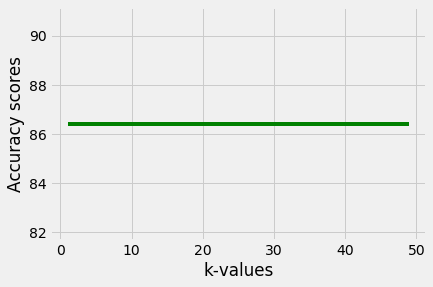

In [0]:
k=[]
s =[]
for i,j in acc_score:
    k.append(j)
    s.append(i)

plt.plot(k,s,color='g')

plt.xlabel("k-values")
plt.ylabel('Accuracy scores')
plt.show()



In [0]:
n=max(acc_score)
n=n[1]
print('Best_k: ',n)

Best_k:  49


In [0]:
knn_brute_w2v=KNeighborsClassifier(n_jobs=2,n_neighbors=n,algorithm='brute')
knn_brute_w2v.fit(x_tr,y_tr)
cv_pred =knn_brute_w2v.predict(x_cv)
cv_acc = accuracy_score(y_cv,cv_pred)
print('Accuracry of Cross_validation:',cv_acc*100)

train_pred =knn_brute_w2v.predict(x_tr)
train_acc =accuracy_score(y_tr,train_pred)
print('Accuracry of Train data:',train_acc*100)

Accuracry of Cross_validation: 86.41975308641975
Accuracry of Train data: 84.34702068539673


In [0]:
roc_auc_cv = roc_auc_score(y_cv,cv_pred)
fpr_cv,tpr_cv,thersholds = roc_curve(y_cv,cv_pred)
fpr_cv=fpr_cv[1]*100
print("False Positive Rate: {}".format(fpr_cv))

tpr_cv=tpr_cv[1]*100
print("True Positive Rate: {}".format(tpr_cv))

False Positive Rate: 100.0
True Positive Rate: 100.0


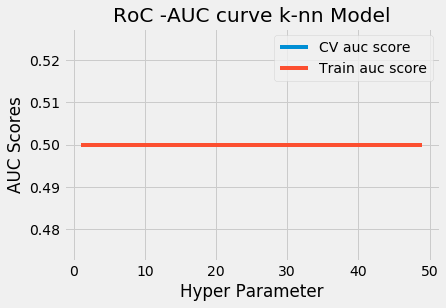

In [0]:
plt.plot(k,cv_auc_scores,label='CV auc score')
plt.plot(k,tr_auc_scores,label='Train auc score')

#plt.ylim([-0.05,1.05])
plt.legend(loc=0)

plt.xlabel('Hyper Parameter')
plt.ylabel('AUC Scores')
plt.title("RoC -AUC curve k-nn Model")

plt.show()

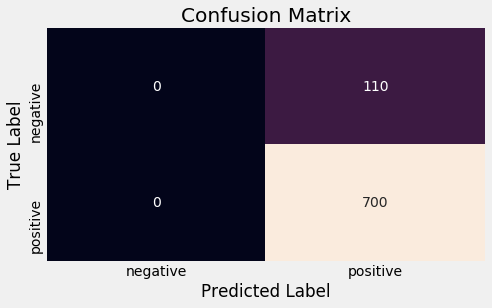

In [0]:
cm=confusion_matrix(y_cv,cv_pred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
plt.figure(figsize=(7,4))
sns.heatmap(df_cm, annot = True,cbar=False,fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### gridsearchCV w2v

In [0]:
 k = list(range(1,51,2))
print(k)   
param_grid=dict(n_neighbors=k)
print(param_grid)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49]
{'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49]}


In [0]:
grid_brute_w2v = GridSearchCV(knn_brute_w2v, param_grid=param_grid,cv=5,scoring='accuracy',n_jobs=4)
grid_brute_w2v.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='brute', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=2,
                                            n_neighbors=49, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=4,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29, 31, 33, 35, 37, 39, 41,
                                         43, 45, 47, 49]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [0]:
print("Best Parameter:",grid_brute_w2v.best_estimator_)
print("Best k-Neighbors:",grid_brute_w2v.best_params_)
print("Bset score:",grid_brute_w2v.best_score_)

Best Parameter: KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=2, n_neighbors=1, p=2,
                     weights='uniform')
Best k-Neighbors: {'n_neighbors': 1}
Bset score: 0.8476166954803656


In [0]:
model_1_w2v  = KNeighborsClassifier(algorithm='brute',metric='minkowski',n_neighbors=grid_brute_w2v.best_params_['n_neighbors'],weights='uniform',n_jobs=4)
model_1_w2v.fit(x_train,y_train)
y_pred_1 = model_1_w2v.predict(x_test)

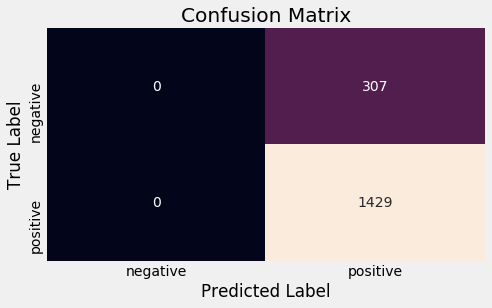

In [0]:
#Reference:
#https://www.kaggle.com/premvardhan/amazon-fine-food-reviews-analysis-using-knn
cm=confusion_matrix(y_test,y_pred_1)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
plt.figure(figsize=(7,4))
sns.heatmap(df_cm, annot = True,cbar=False,fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()

In [0]:
acc = accuracy_score(y_test,y_pred_1)*float(100)
print('Accuracy on Test Data : {:.2f} with k={}'.format(acc,grid_brute_w2v.best_params_['n_neighbors']))
print("Accuracy on Train Data :{:.2f} with k={}".format(grid_brute_w2v.best_score_*100,grid_brute_w2v.best_params_['n_neighbors']))

Accuracy on Test Data : 82.32 with k=1
Accuracy on Train Data :84.76 with k=1


### ROC and AUC

In [0]:
roc_auc_test_w2v = roc_auc_score(y_test,y_pred_1)
fpr_test,tpr_test,thersholds_test = roc_curve(y_test,model_1_w2v.predict_proba(x_test)[:,1])

roc_auc_train_w2v = roc_auc_score(y_train,model_1_w2v.predict(x_train))
fpr_train,tpr_train,thersholds_train = roc_curve(y_train,model_1_w2v.predict_proba(x_train)[:,1])

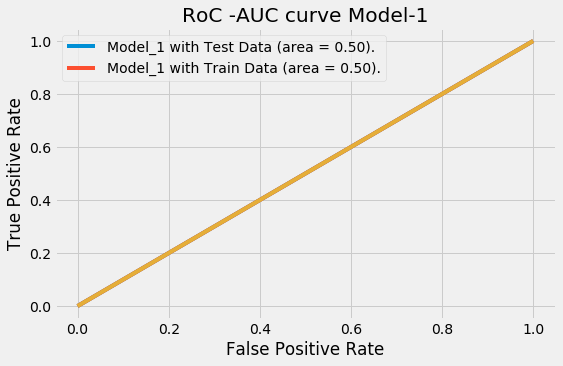

In [0]:
plt.figure(figsize=(8,5))
plt.style.use('fivethirtyeight')
plt.plot(fpr_test,tpr_test,label='Model_1 with Test Data (area = %.2f).'% roc_auc_test_w2v)
plt.plot(fpr_train,tpr_train,label='Model_1 with Train Data (area = %.2f).'% roc_auc_train_w2v)
plt.plot([0,1],[0,1])
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend(loc=0)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("RoC -AUC curve Model-1")

plt.show()

In [0]:
fpr=fpr_test[1]*100
print("False Positive Rate: {}".format(fpr))

tpr=tpr_test[1]*100
print("True Positive Rate: {}".format(tpr))

False Positive Rate: 100.0
True Positive Rate: 100.0


##7.4.2 W2V with kd-tree

In [0]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=999)
x_train.shape

(4049, 50)

In [0]:
#split train data into cross validation train and cross validation test
x_tr,x_cv,y_tr,y_cv = train_test_split(x_train,y_train,test_size=0.2,random_state=99)

acc_score=[]
cv_auc_scores = []
tr_auc_scores = []


for i in range(1,50,2):
    knn_kd_w2v = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree',n_jobs=4)
    knn_kd_w2v.fit(x_tr,y_tr)
    pred_cv= knn_kd_w2v.predict(x_cv)
    pred_tr = knn_kd_w2v.predict(x_tr)
    
    acc = accuracy_score(y_cv,pred_cv,normalize=True)*float(100)
    acc_score.append((acc,i))
    
    roc_auc_cv = roc_auc_score(y_cv,pred_cv)
    fpr_cv,tpr_cv,thersholds_cv = roc_curve(y_cv,knn_kd_w2v.predict_proba(x_cv)[:,1])
    cv_auc_scores.append(auc(fpr_cv,tpr_cv))
    

    roc_auc_tr = roc_auc_score(y_tr,pred_tr)
    fpr_tr,tpr_tr,thersholds_tr = roc_curve(y_tr,knn_kd_w2v.predict_proba(x_tr)[:,1])
    tr_auc_scores.append(auc(fpr_tr,tpr_tr))
    
    print("\nCV Accuracy for k={} is {:.2f}".format(i,acc))
    
print(10*'===')
print("Best accuracy:",max(acc_score))


CV Accuracy for k=1 is 86.42

CV Accuracy for k=3 is 86.42

CV Accuracy for k=5 is 86.42

CV Accuracy for k=7 is 86.42

CV Accuracy for k=9 is 86.42

CV Accuracy for k=11 is 86.42

CV Accuracy for k=13 is 86.42

CV Accuracy for k=15 is 86.42

CV Accuracy for k=17 is 86.42

CV Accuracy for k=19 is 86.42

CV Accuracy for k=21 is 86.42

CV Accuracy for k=23 is 86.42

CV Accuracy for k=25 is 86.42

CV Accuracy for k=27 is 86.42

CV Accuracy for k=29 is 86.42

CV Accuracy for k=31 is 86.42

CV Accuracy for k=33 is 86.42

CV Accuracy for k=35 is 86.42

CV Accuracy for k=37 is 86.42

CV Accuracy for k=39 is 86.42

CV Accuracy for k=41 is 86.42

CV Accuracy for k=43 is 86.42

CV Accuracy for k=45 is 86.42

CV Accuracy for k=47 is 86.42

CV Accuracy for k=49 is 86.42
Best accuracy: (86.41975308641975, 49)


In [0]:
n=max(acc_score)
n = n[1]
n

49

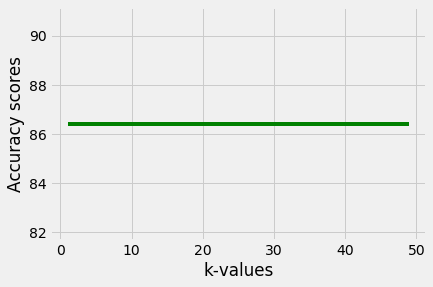

In [0]:
k=[]
s =[]
for i,j in acc_score:
    k.append(j)
    s.append(i)

plt.plot(k,s,color='g')

plt.xlabel("k-values")
plt.ylabel('Accuracy scores')
plt.show()


In [0]:
knn_kd_w2v =KNeighborsClassifier(n_jobs=4,n_neighbors=n,algorithm='kd_tree')
knn_kd_w2v.fit(x_tr,y_tr)
cv_pred =knn_kd_w2v.predict(x_cv)
cv_acc = accuracy_score(y_cv,cv_pred)
print('Accuracry of Cross_validation:',cv_acc*100)

Accuracry of Cross_validation: 86.41975308641975


In [0]:
train_pred =knn_kd_w2v.predict(x_tr)
train_acc =accuracy_score(y_tr,train_pred)
print('Accuracry of Train data:',train_acc*100)

Accuracry of Train data: 84.34702068539673


In [0]:
roc_auc_cv = roc_auc_score(y_cv,cv_pred)
fpr_cv,tpr_cv,thersholds = roc_curve(y_cv,cv_pred)
fpr_cv=fpr_cv[1]*100
print("False Positive Rate: {}".format(fpr_cv))

tpr_cv=tpr_cv[1]*100
print("True Positive Rate: {}".format(tpr_cv))

False Positive Rate: 100.0
True Positive Rate: 100.0


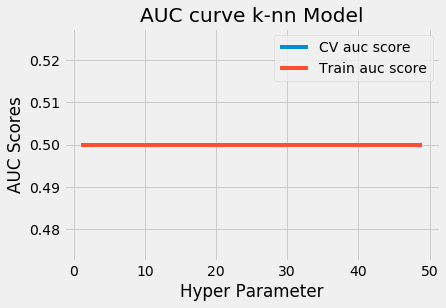

In [0]:
plt.plot(k,cv_auc_scores,label='CV auc score')
plt.plot(k,tr_auc_scores,label='Train auc score')

#plt.ylim([-0.05,1.05])
plt.legend(loc=0)

plt.xlabel('Hyper Parameter')
plt.ylabel('AUC Scores')
plt.title("AUC curve k-nn Model")

plt.show()

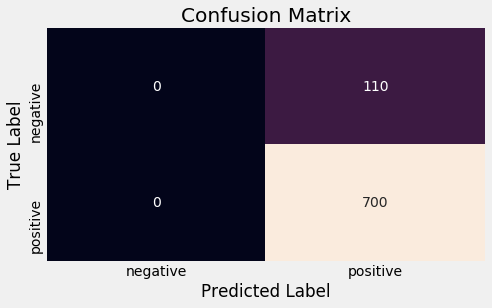

In [0]:
cm=confusion_matrix(y_cv,cv_pred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
plt.figure(figsize=(7,4))
sns.heatmap(df_cm, annot = True,cbar=False,fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### gridSearchCV 

In [0]:
knn_kd_w2v = KNeighborsClassifier(n_neighbors=n,algorithm='kd_tree', n_jobs=4)

grid_kd_w2v = GridSearchCV(knn_kd_w2v, param_grid=param_grid,cv=3,scoring='accuracy',n_jobs=4)
grid_kd_w2v.fit(x_train,y_train)
 

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='kd_tree', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=4,
                                            n_neighbors=49, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=4,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29, 31, 33, 35, 37, 39, 41,
                                         43, 45, 47, 49]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [0]:
print("Best Parameter:",grid_kd_w2v.best_estimator_)
print("Best Neighbors:",grid_kd_w2v.best_params_)
print("Bset score:",grid_kd_w2v.best_score_)

Best Parameter: KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=4, n_neighbors=1, p=2,
                     weights='uniform')
Best Neighbors: {'n_neighbors': 1}
Bset score: 0.8476166954803656


In [0]:
model_2_kd_w2v = KNeighborsClassifier(n_jobs=4,n_neighbors=grid_kd_w2v.best_params_['n_neighbors'],metric='minkowski',algorithm='kd_tree',weights='uniform')
model_2_kd_w2v.fit(x_train,y_train)
y_pred_2 = model_2_kd_w2v.predict(x_test)
y_train_2 = model_2_kd_w2v.predict(x_train)

In [0]:
test_acc_2 =accuracy_score(y_test,y_pred_2)
train_acc_2 = accuracy_score(y_train,y_train_2)

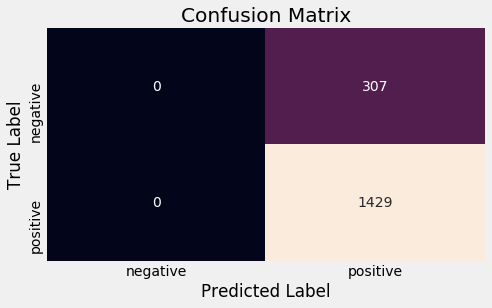

In [0]:
cm=confusion_matrix(y_test,y_pred_2)
#Reference:
#https://www.kaggle.com/premvardhan/amazon-fine-food-reviews-analysis-using-knn
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
plt.figure(figsize=(7,4))
sns.heatmap(df_cm, annot = True,cbar=False,fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()


In [0]:
acc = accuracy_score(y_test,y_pred_2)*float(100)
print('Accuracy on Test Data : {} with k={}'.format(test_acc_2*100,grid_kd_w2v.best_params_['n_neighbors']))
print("Accuracy on Train Data :{} with k={}".format(train_acc_2*100,grid_kd_w2v.best_params_['n_neighbors']))

Accuracy on Test Data : 82.31566820276498 with k=1
Accuracy on Train Data :84.76166954803655 with k=1


In [0]:
roc_auc_test_2_w2v = roc_auc_score(y_test,y_pred_1)
fpr_test_2,tpr_test_2,thersholds = roc_curve(y_test,model_2_kd_w2v.predict_proba(x_test)[:,1])

roc_auc_train_2 = roc_auc_score(y_train,y_train_2)
fpr_train_2,tpr_train_2,thersholds_2 = roc_curve(y_test,model_2_kd_w2v.predict_proba(x_test)[:,1])

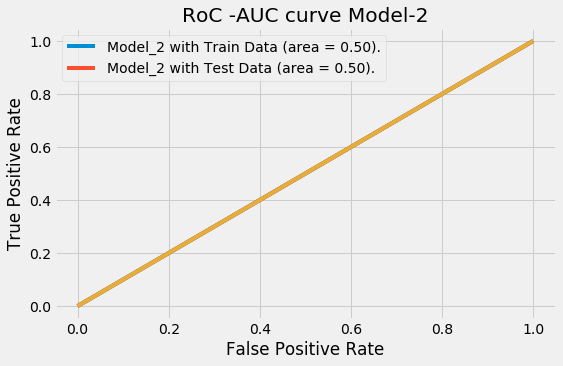

In [0]:
plt.figure(figsize=(8,5))
plt.plot(fpr_train_2,tpr_train_2,label='Model_2 with Train Data (area = %.2f).'% roc_auc_train_2)
plt.plot(fpr_test_2,tpr_test_2,label='Model_2 with Test Data (area = %.2f).'% roc_auc_test_2_w2v)
plt.plot([0,1],[0,1])
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend(loc=0)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("RoC -AUC curve Model-2")

plt.show()

### 7.4.3 Comparing KD-tree and Bruteforce models of W2V

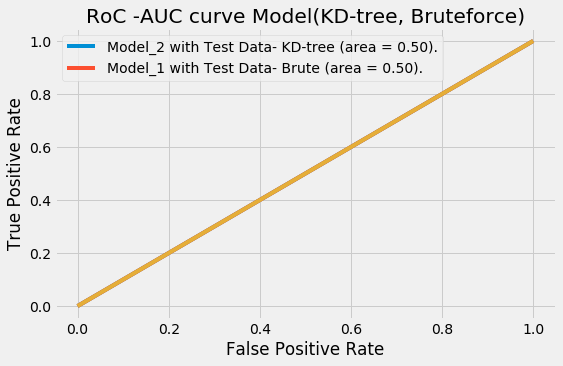

In [0]:
plt.figure(figsize=(8,5))
plt.plot(fpr_test_2,tpr_test_2,label='Model_2 with Test Data- KD-tree (area = %.2f).'% roc_auc_test_2_w2v)
plt.plot(fpr_test,tpr_test,label='Model_1 with Test Data- Brute (area = %.2f).'% roc_auc_test_w2v)
plt.plot([0,1],[0,1])
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("RoC -AUC curve Model(KD-tree, Bruteforce)",loc='center')
plt.show()


In [0]:
kd_tree_auc_w2v = auc(fpr_test_2,tpr_test_2)
brute_auc_w2v = auc(fpr_test,tpr_test)
print("AUC kd-tee: %.2f"% kd_tree_auc_w2v)
print("AUC brute: %.2f"% brute_auc_w2v)

AUC kd-tee: 0.50
AUC brute: 0.50


# Conclusion: W2V

In [0]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = [ "Vectorizer","Model","Hyper Parameter(k)", 'AUC']
x.add_row(["BoW", "Brute", grid_brute_w2v.best_params_['n_neighbors'], np.round(brute_auc_w2v,2)])
x.add_row(["BoW", "KD-tree", grid_kd_w2v.best_params_['n_neighbors'],np.round(kd_tree_auc_w2v,2)])

print(x)

+------------+---------+--------------------+-----+
| Vectorizer |  Model  | Hyper Parameter(k) | AUC |
+------------+---------+--------------------+-----+
|    BoW     |  Brute  |         1          | 0.5 |
|    BoW     | KD-tree |         1          | 0.5 |
+------------+---------+--------------------+-----+


# 7.5- TFIDF weighted W2V

In [0]:
tf_model = TfidfVectorizer()
tf_model.fit(preprocessed_reviews)
dictionary = dict(zip(tf_model.get_feature_names(),list(tf_model.idf_)))

In [0]:
dictionary.items()

dict_items([('aa', 8.276902124416189), ('aahhhs', 8.970049304976136), ('aback', 8.970049304976136), ('abandon', 8.970049304976136), ('abates', 8.970049304976136), ('abbott', 8.970049304976136), ('abby', 8.970049304976136), ('abdominal', 8.970049304976136), ('abiding', 8.970049304976136), ('ability', 7.26530121273771), ('able', 4.545202673119325), ('abnormalities', 8.970049304976136), ('abor', 8.970049304976136), ('aboulutely', 8.970049304976136), ('absence', 8.05375857310198), ('absent', 8.05375857310198), ('absoloutely', 8.970049304976136), ('absolute', 6.197460582736354), ('absolutely', 4.665984211771965), ('absolutley', 8.970049304976136), ('absolutly', 8.276902124416189), ('absorb', 7.717286336480767), ('absorbed', 8.05375857310198), ('absorbs', 8.970049304976136), ('abt', 8.970049304976136), ('abu', 8.970049304976136), ('abundant', 8.970049304976136), ('abuse', 8.276902124416189), ('abut', 8.970049304976136), ('acacia', 8.970049304976136), ('academy', 8.970049304976136), ('acai', 

## TF-IDF weighted Word2Vec



In [0]:
tfidf_feat = tf_model.get_feature_names()

tfidf_sent_vectors =[]

row =0

for sent in tqdm(list_of_sentence):
    sent_vec = np.zeros(50)
    weight_sum =0
    
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec*tf_idf)
            weight_sum +=tf_idf
            
    if weight_sum !=0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row +=1

100%|██████████| 5785/5785 [00:36<00:00, 159.38it/s]


In [0]:
tfidf_sent_vectors[0]

array([-0.35208562, -0.27892875, -0.3627583 , -0.11509588, -0.49706044,
       -0.34841905,  0.47553488,  0.26693182, -0.80859793,  0.12332067,
       -0.0186318 ,  0.48230622, -0.09518262,  0.42000838, -0.21394064,
       -0.69289736,  0.06630605,  0.37614809,  0.65753763, -0.34224116,
        0.27450598, -0.64875922, -0.24690778, -0.04355849, -0.01255597,
        0.15592966, -0.32403858, -0.535782  , -0.10199807,  0.38466177,
        0.08196014, -0.73026864,  0.11218798,  0.23657866,  0.33194305,
        0.07842717,  0.25500094,  0.20357387, -0.34569187, -0.32576729,
       -0.01110526,  0.59988418,  0.21137564,  0.15575945, -0.20090125,
        0.27120186, -0.80431672,  0.06585632,  0.19688126,  0.16125232])

In [0]:
x= np.array(tfidf_sent_vectors)
print(type(x))
print(x.shape)

print(x.shape)
print(type(x))

y =np.array( df['Score'])
print(y.shape)

<class 'numpy.ndarray'>
(5785, 50)
(5785, 50)
<class 'numpy.ndarray'>
(5785,)


In [0]:
scalar = StandardScaler()
x=scalar.fit_transform(x)

In [0]:
x.shape

(5785, 50)

In [0]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=909)
x_train.shape

(4049, 50)

## Apply K-NN (brute force version) on these feature sets

In [0]:
#split train data into cross validation train and cross validation test
x_tr,x_cv,y_tr,y_cv = train_test_split(x_train,y_train,test_size=0.2,random_state=99)

acc_score=[]
cv_auc_scores = []
tr_auc_scores = []


for i in range(1,50,2):
    knn_brute_tf_w2v = KNeighborsClassifier(n_neighbors=i,algorithm='brute',n_jobs=4)
    knn_brute_tf_w2v.fit(x_tr,y_tr)
    pred_cv= knn_brute_tf_w2v.predict(x_cv)
    pred_tr = knn_brute_tf_w2v.predict(x_tr)
    
    acc = accuracy_score(y_cv,pred_cv,normalize=True)*float(100)
    acc_score.append((acc,i))
    
    roc_auc_cv = roc_auc_score(y_cv,pred_cv)
    fpr_cv,tpr_cv,thersholds_cv = roc_curve(y_cv,knn_brute_tf_w2v.predict_proba(x_cv)[:,1])
    cv_auc_scores.append(auc(fpr_cv,tpr_cv))
    

    roc_auc_tr = roc_auc_score(y_tr,pred_tr)
    fpr_tr,tpr_tr,thersholds_tr = roc_curve(y_tr,knn_brute_tf_w2v.predict_proba(x_tr)[:,1])
    tr_auc_scores.append(auc(fpr_tr,tpr_tr))
    
    print("\nCV Accuracy for k={} is {:.2f}".format(i,acc))
    
print(10*'===')
print("Best accuracy:",max(acc_score))


CV Accuracy for k=1 is 76.17

CV Accuracy for k=3 is 80.49

CV Accuracy for k=5 is 81.60

CV Accuracy for k=7 is 83.70

CV Accuracy for k=9 is 84.57

CV Accuracy for k=11 is 84.81

CV Accuracy for k=13 is 85.06

CV Accuracy for k=15 is 84.81

CV Accuracy for k=17 is 84.94

CV Accuracy for k=19 is 85.06

CV Accuracy for k=21 is 85.06

CV Accuracy for k=23 is 85.06

CV Accuracy for k=25 is 85.06

CV Accuracy for k=27 is 85.19

CV Accuracy for k=29 is 85.19

CV Accuracy for k=31 is 85.31

CV Accuracy for k=33 is 85.19

CV Accuracy for k=35 is 85.19

CV Accuracy for k=37 is 85.19

CV Accuracy for k=39 is 85.19

CV Accuracy for k=41 is 85.19

CV Accuracy for k=43 is 85.31

CV Accuracy for k=45 is 85.31

CV Accuracy for k=47 is 85.31

CV Accuracy for k=49 is 85.31
Best accuracy: (85.30864197530865, 49)


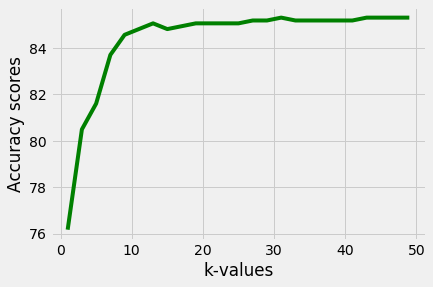

In [0]:
k=[]
s =[]
for i,j in acc_score:
    k.append(j)
    s.append(i)

plt.plot(k,s,color='g')

plt.xlabel("k-values")
plt.ylabel('Accuracy scores')
plt.show()



In [0]:
n=max(acc_score)
n=n[1]
print('Best_k: ',n)

Best_k:  49


In [0]:
knn_brute_tf_w2v=KNeighborsClassifier(n_jobs=2,n_neighbors=n,algorithm='brute')
knn_brute_tf_w2v.fit(x_tr,y_tr)
cv_pred =knn_brute_tf_w2v.predict(x_cv)
cv_acc = accuracy_score(y_cv,cv_pred)
print('Accuracry of Cross_validation:',cv_acc*100)

Accuracry of Cross_validation: 85.30864197530865


In [0]:
train_pred =knn_brute_tf_w2v.predict(x_tr)
train_acc =accuracy_score(y_tr,train_pred)
print('Accuracry of Train data:',train_acc*100)

Accuracry of Train data: 83.60605125038593


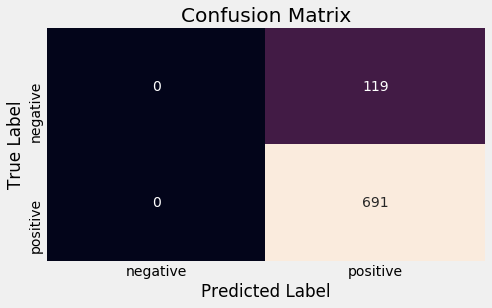

In [0]:
cm=confusion_matrix(y_cv,cv_pred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
plt.figure(figsize=(7,4))
sns.heatmap(df_cm, annot = True,cbar=False,fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## GridSearchCV -tf_w2v

In [0]:
k = list(range(1,51,2))
print(k)   
param_grid=dict(n_neighbors=k)
print(param_grid)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49]
{'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49]}


In [0]:
grid_brute_tf_w2v = GridSearchCV(knn_brute_tf_w2v, param_grid=param_grid,cv=5,scoring='accuracy',n_jobs=4)
grid_brute_tf_w2v.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='brute', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=2,
                                            n_neighbors=49, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=4,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29, 31, 33, 35, 37, 39, 41,
                                         43, 45, 47, 49]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [0]:
print("Best Parameter:",grid_brute_tf_w2v.best_estimator_)
print("Best k-Neighbors:",grid_brute_tf_w2v.best_params_)
print("Bset score:",grid_brute_tf_w2v.best_score_)

Best Parameter: KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=2, n_neighbors=33, p=2,
                     weights='uniform')
Best k-Neighbors: {'n_neighbors': 33}
Bset score: 0.8394665349469005


In [0]:
model_1_tf_w2v  = KNeighborsClassifier(algorithm='brute',metric='minkowski',n_neighbors=grid_brute_tf_w2v.best_params_['n_neighbors'],weights='uniform',n_jobs=4)
model_1_tf_w2v.fit(x_train,y_train)
y_pred_1 = model_1_tf_w2v.predict(x_test)

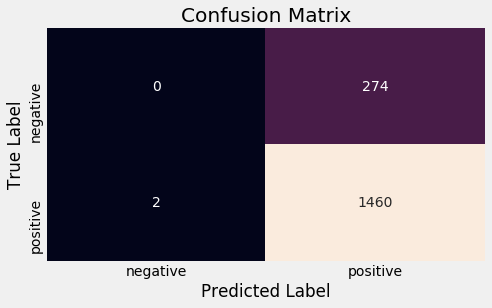

In [0]:
#Reference:
#https://www.kaggle.com/premvardhan/amazon-fine-food-reviews-analysis-using-knn
cm=confusion_matrix(y_test,y_pred_1)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
plt.figure(figsize=(7,4))
sns.heatmap(df_cm, annot = True,cbar=False,fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()

In [0]:
acc = accuracy_score(y_test,y_pred_1)*float(100)
print('Accuracy on Test Data : {:.2f} with k={}'.format(acc,grid_brute_tf_w2v.best_params_['n_neighbors']))
print("Accuracy on Train Data :{:.2f} with k={}".format(grid_brute_tf_w2v.best_score_*100,grid_brute_tf_w2v.best_params_['n_neighbors']))

Accuracy on Test Data : 84.10 with k=33
Accuracy on Train Data :83.95 with k=33


### ROC and AUC

In [0]:
roc_auc_test_tf_w2v = roc_auc_score(y_test,y_pred_1)
fpr_test,tpr_test,thersholds_test = roc_curve(y_test,model_1_tf_w2v.predict_proba(x_test)[:,1])

roc_auc_train_tf_w2v = roc_auc_score(y_train,model_1_tf_w2v.predict(x_train))
fpr_train,tpr_train,thersholds_train = roc_curve(y_train,model_1_tf_w2v.predict_proba(x_train)[:,1])

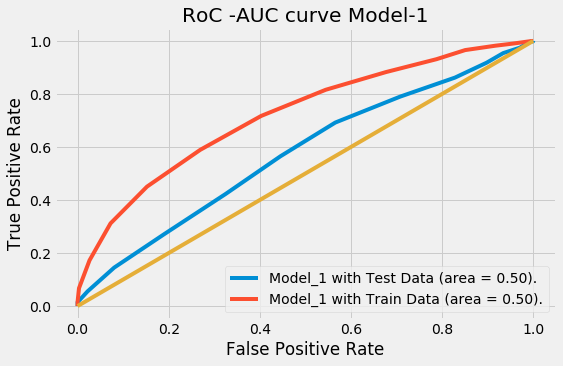

In [0]:
plt.figure(figsize=(8,5))
plt.style.use('fivethirtyeight')
plt.plot(fpr_test,tpr_test,label='Model_1 with Test Data (area = %.2f).'% roc_auc_test_tf_w2v)
plt.plot(fpr_train,tpr_train,label='Model_1 with Train Data (area = %.2f).'% roc_auc_train_tf_w2v)
plt.plot([0,1],[0,1])
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend(loc=0)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("RoC -AUC curve Model-1")

plt.show()

In [0]:
fpr=fpr_test[1]*100
print("False Positive Rate: {}".format(fpr))

tpr=tpr_test[1]*100
print("True Positive Rate: {}".format(tpr))

False Positive Rate: 0.0
True Positive Rate: 1.4363885088919288


##TF-IDF -w2v with kd-tree

In [0]:
#split train data into cross validation train and cross validation test
x_tr,x_cv,y_tr,y_cv = train_test_split(x_train,y_train,test_size=0.2,random_state=199)

acc_score=[]
cv_auc_scores = []
tr_auc_scores = []


for i in range(1,50,2):
    knn_kd_tf_w2v = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree',n_jobs=4)
    knn_kd_tf_w2v.fit(x_tr,y_tr)
    pred_cv= knn_kd_tf_w2v.predict(x_cv)
    pred_tr = knn_kd_tf_w2v.predict(x_tr)
    
    acc = accuracy_score(y_cv,pred_cv,normalize=True)*float(100)
    acc_score.append((acc,i))
    
   
    print("\nCV Accuracy for k={} is {:.2f}".format(i,acc))
    
print(10*'===')
print("Best accuracy:",max(acc_score))


CV Accuracy for k=1 is 76.79

CV Accuracy for k=3 is 78.02

CV Accuracy for k=5 is 80.49

CV Accuracy for k=7 is 82.10

CV Accuracy for k=9 is 81.98

CV Accuracy for k=11 is 82.72

CV Accuracy for k=13 is 82.84

CV Accuracy for k=15 is 83.09

CV Accuracy for k=17 is 83.33

CV Accuracy for k=19 is 83.46

CV Accuracy for k=21 is 83.58

CV Accuracy for k=23 is 83.58

CV Accuracy for k=25 is 83.70

CV Accuracy for k=27 is 83.70

CV Accuracy for k=29 is 83.58

CV Accuracy for k=31 is 83.70

CV Accuracy for k=33 is 83.58

CV Accuracy for k=35 is 83.58

CV Accuracy for k=37 is 83.58

CV Accuracy for k=39 is 83.58

CV Accuracy for k=41 is 83.58

CV Accuracy for k=43 is 83.58

CV Accuracy for k=45 is 83.58

CV Accuracy for k=47 is 83.58

CV Accuracy for k=49 is 83.58
Best accuracy: (83.7037037037037, 31)


In [0]:
n=max(acc_score)
n = n[1]
n

31

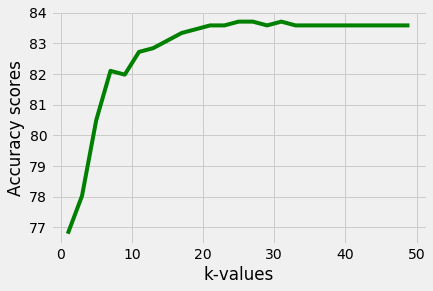

In [0]:
k=[]
s =[]
for i,j in acc_score:
    k.append(j)
    s.append(i)

plt.plot(k,s,color='g')

plt.xlabel("k-values")
plt.ylabel('Accuracy scores')
plt.show()


In [0]:
knn_kd_tf_w2v=KNeighborsClassifier(n_jobs=4,n_neighbors=n,algorithm='kd_tree')
knn_kd_tf_w2v.fit(x_tr,y_tr)
cv_pred =knn_kd_tf_w2v.predict(x_cv)
cv_acc = accuracy_score(y_cv,cv_pred)
print('Accuracry of Cross_validation:',cv_acc*100)

Accuracry of Cross_validation: 83.7037037037037


In [0]:
train_pred =knn_kd_tf_w2v.predict(x_tr)
train_acc =accuracy_score(y_tr,train_pred)
print('Accuracry of Train data:',train_acc*100)

Accuracry of Train data: 84.06915714726767


In [0]:
test_pred =knn_kd_tf_w2v.predict(x_test)
test_acc =accuracy_score(y_test,test_pred)
print('Accuracry of Test data:',test_acc*100)

Accuracry of Test data: 84.10138248847926


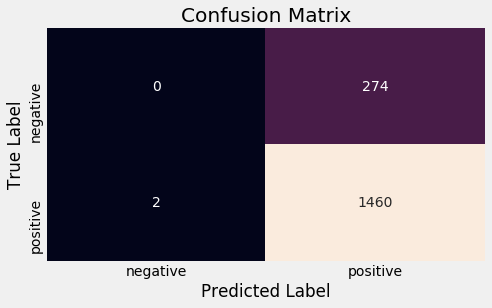

In [0]:
cm=confusion_matrix(y_test,test_pred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
plt.figure(figsize=(7,4))
sns.heatmap(df_cm, annot = True,cbar=False,fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### GridSearchCV

In [0]:
grid_kd_tf_w2v =  GridSearchCV(knn_kd_tf_w2v, param_grid=param_grid,cv=3,scoring='accuracy',n_jobs=4)
grid_kd_tf_w2v.fit(x_train,y_train)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='kd_tree', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=4,
                                            n_neighbors=31, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=4,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29, 31, 33, 35, 37, 39, 41,
                                         43, 45, 47, 49]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [0]:
print("Best Parameter:",grid_kd_tf_w2v.best_estimator_)
print("Best Neighbors:",grid_kd_tf_w2v.best_params_)
print("Bset score:",grid_kd_tf_w2v.best_score_)

Best Parameter: KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=4, n_neighbors=31, p=2,
                     weights='uniform')
Best Neighbors: {'n_neighbors': 31}
Bset score: 0.8394665349469005


In [0]:
model_2_kd_tf_w2v = KNeighborsClassifier(n_jobs=4,n_neighbors=grid_kd_tf_w2v.best_params_['n_neighbors'],metric='minkowski',algorithm='kd_tree',weights='uniform')
model_2_kd_tf_w2v.fit(x_train,y_train)
y_pred_2 = model_2_kd_tf_w2v.predict(x_test)
y_train_2 = model_2_kd_tf_w2v.predict(x_train)

In [0]:
test_acc_2 =accuracy_score(y_test,y_pred_2)
train_acc_2 = accuracy_score(y_train,y_train_2)

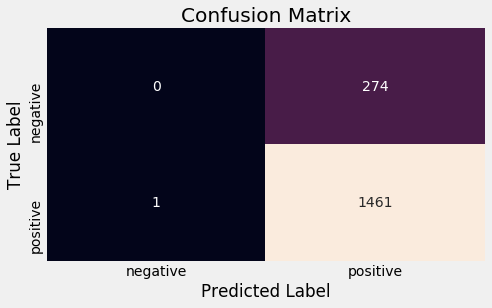

In [0]:
cm=confusion_matrix(y_test,y_pred_2)
#Reference:
#https://www.kaggle.com/premvardhan/amazon-fine-food-reviews-analysis-using-knn
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
plt.figure(figsize=(7,4))
sns.heatmap(df_cm, annot = True,cbar=False,fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()


In [0]:
acc = accuracy_score(y_test,y_pred_2)*float(100)
print('Accuracy on Test Data : {} with k={}'.format(test_acc_2*100,grid_kd_tf_w2v.best_params_['n_neighbors']))
print("Accuracy on Train Data :{} with k={}".format(train_acc_2*100,grid_kd_tf_w2v.best_params_['n_neighbors']))

Accuracy on Test Data : 84.1589861751152 with k=31
Accuracy on Train Data :83.94665349469005 with k=31


In [0]:
y_pred_2 = model_2_kd_tf_w2v.predict(x_test)
y_train_2 = model_2_kd_tf_w2v.predict(x_train)

In [0]:
roc_auc_test_tf_w2v_2 = roc_auc_score(y_test,y_pred_2)
fpr_test_2,tpr_test_2,thersholds_test = roc_curve(y_test,model_2_kd_tf_w2v.predict_proba(x_test)[:,1])

roc_auc_train_tf_w2v_2= roc_auc_score(y_train,y_train_2)
fpr_train,tpr_train,thersholds_train = roc_curve(y_train,model_2_kd_tf_w2v.predict_proba(x_train)[:,1])

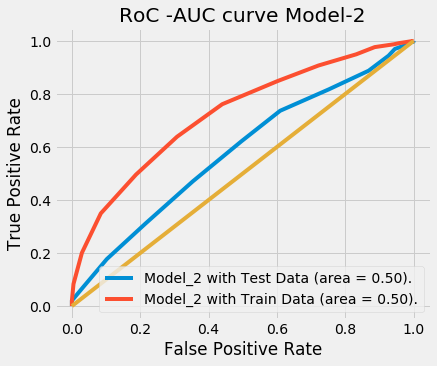

In [0]:
plt.figure(figsize=(6,5))
plt.style.use('fivethirtyeight')
plt.plot(fpr_test_2,tpr_test_2,label='Model_2 with Test Data (area = %.2f).'% roc_auc_test_tf_w2v_2)
plt.plot(fpr_train,tpr_train,label='Model_2 with Train Data (area = %.2f).'% roc_auc_train_tf_w2v_2)
plt.plot([0,1],[0,1])
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend(loc=0)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("RoC -AUC curve Model-2")

plt.show()

## Comparing KD-tree and Bruteforce models of Tf-Idf-w2v

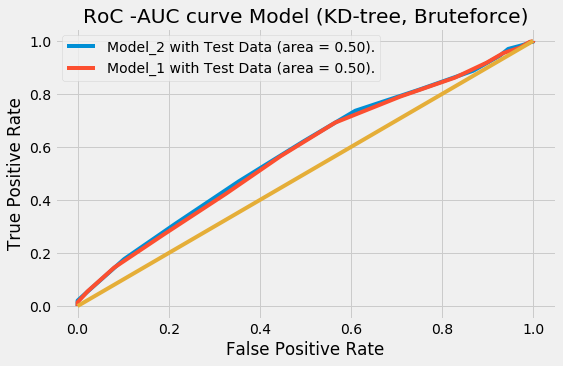

In [0]:
plt.figure(figsize=(8,5))
plt.plot(fpr_test_2,tpr_test_2,label='Model_2 with Test Data (area = %.2f).'% roc_auc_test_tf_w2v_2)
plt.plot(fpr_test,tpr_test,label='Model_1 with Test Data (area = %.2f).'% roc_auc_test_tf_w2v)
plt.plot([0,1],[0,1])
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("RoC -AUC curve Model (KD-tree, Bruteforce)")
plt.show()


# Conclusion:TF-IDF W2V

In [0]:
kd_tree_auc_tf_w2v = auc(fpr_test_2,tpr_test_2)
brute_auc_tf_w2v = auc(fpr_test,tpr_test)
print("AUC kd-tee: %.2f"% kd_tree_auc_tf_w2v)
print("AUC brute: %.2f"% brute_auc_tf_w2v)

AUC kd-tee: 0.58
AUC brute: 0.58


In [0]:
x = PrettyTable()

x.field_names = [ "Vectorizer","Model","Hyper Parameter(k)", 'AUC']
x.add_row(["BoW", "Brute", grid_brute_tf_w2v.best_params_['n_neighbors'], np.round(brute_auc_tf_w2v,2)])
x.add_row(["BoW", "KD-tree", grid_kd_tf_w2v.best_params_['n_neighbors'],np.round(kd_tree_auc_tf_w2v,2)])

print(x)

+------------+---------+--------------------+------+
| Vectorizer |  Model  | Hyper Parameter(k) | AUC  |
+------------+---------+--------------------+------+
|    BoW     |  Brute  |         33         | 0.58 |
|    BoW     | KD-tree |         31         | 0.58 |
+------------+---------+--------------------+------+


# Final conclusion

In [0]:
x = PrettyTable()

x.field_names = [ "Vectorizer","Model","Hyper Parameter(k)", 'AUC']
x.add_row(["tf-idf_w2v", "Brute", grid_brute_tf_w2v.best_params_['n_neighbors'], np.round(brute_auc_tf_w2v,2)])
x.add_row(["tf-idf_w2v", "KD-tree", grid_kd_tf_w2v.best_params_['n_neighbors'],np.round(kd_tree_auc_tf_w2v,2)])
x.add_row(["W2V", "Brute", grid_brute_w2v.best_params_['n_neighbors'], np.round(brute_auc_w2v,2)])
x.add_row(["W2V", "KD-tree", grid_kd_w2v.best_params_['n_neighbors'],np.round(kd_tree_auc_w2v,2)])
x.add_row(["TF-IDF", "Brute", grid_brute_tf.best_params_['n_neighbors'], np.round(brute_auc_tf,2)])
x.add_row(["TF-IDF", "KD-tree", grid_kd_tf.best_params_['n_neighbors'],np.round(kd_tree_auc_tf,2)])
#x.add_row(["BoW", "Brute", grid_brute_bow.best_params_['n_neighbors'], np.round(brute_auc_bow,2)])
#.add_row(["BoW", "KD-tree", grid_kd_bow.best_params_['n_neighbors'],np.round(kd_tree_auc_bow,2)])

print(x)



+------------+---------+--------------------+------+
| Vectorizer |  Model  | Hyper Parameter(k) | AUC  |
+------------+---------+--------------------+------+
| tf-idf_w2v |  Brute  |         33         | 0.58 |
| tf-idf_w2v | KD-tree |         31         | 0.58 |
|    W2V     |  Brute  |         1          | 0.5  |
|    W2V     | KD-tree |         1          | 0.5  |
|   TF-IDF   |  Brute  |         7          | 0.59 |
|   TF-IDF   | KD-tree |         9          | 0.66 |
+------------+---------+--------------------+------+
